### 데이터 구축(hyper parameter)

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import json
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import zipfile
import shutil
from keras.optimizers import Adam, Nadam, AdamW
# from unidecode import unidecode

In [8]:
# 주어진 경로들
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/data/top_crop_data_100000.zip'
extract_path = '/content/images'
target_folder = 'top_crop_data_100000/top_crop_image_100000'

# 압축 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# target_folder 내부 의류 카테고리 폴더까지 접근, 각 폴더 안의 이미지 파일 개수 반환
top_path = os.path.join(extract_path, target_folder)
folders = os.listdir(top_path)

folder_info = {}

for folder in folders:
    folder_path = os.path.join(top_path, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        file_count = len(files)
        folder_info[folder] = file_count

# 결과 출력
for folder, count in folder_info.items():
    print(f"Folder: {folder}, Number of files: {count}")


Folder: tshirts, Number of files: 19678
Folder: shirts, Number of files: 19685
Folder: blaus, Number of files: 19859
Folder: neatwear, Number of files: 19753
Folder: top, Number of files: 19762


In [9]:
# 데이터 저장 리스트
data = []

# JSON 파일을 처리하는 함수
def process_json_file(file_path, image_directory):
    with open(file_path, 'r', encoding='utf-8') as file:
        annotation_data = json.load(file)

        image_info = annotation_data["이미지 정보"]
        label_info = annotation_data["데이터셋 정보"]["데이터셋 상세설명"]["라벨링"]

        # '색상' 및 '카테고리' 키 유효성 검사
        if "색상" not in label_info["상의"][0] or "카테고리" not in label_info["상의"][0]:
            print(f"파일에 필요한 키가 없습니다: {file_path}. 해당 항목을 건너뜁니다.")
            return

        file_path = os.path.join(image_directory, '%d.jpg' % image_info['이미지 식별자'])
        style = label_info["상의"][0]["카테고리"]
        color = label_info["상의"][0]['색상']

        data.append({
            "파일경로": file_path,
            "style": style,
            "color": color,
        })

# top label, image 폴더 경로
top_label_path = '/content/images/top_crop_data_100000/top_crop_label_100000'
top_image_path = "/content/images/top_crop_data_100000/top_crop_image_100000"
# label 폴더들
categories = ["blaus_256", "neatwear_256", "shirts_256", "tshirts_256", "top_256"]

for category in categories:
    category_path = os.path.join(top_label_path, category)
    json_files = [f for f in os.listdir(category_path) if f.endswith('.json')]
    modified_category = category[:-4]
    image_directory = os.path.join(top_image_path, modified_category)

    for json_file in json_files:
        process_json_file(os.path.join(category_path, json_file), image_directory)

# 데이터 프레임 생성
df = pd.DataFrame(data)

# 라벨 인코딩
label_encoder_style = LabelEncoder()
label_encoder_color = LabelEncoder()

df['style'] = label_encoder_style.fit_transform(df['style'])
df['color'] = label_encoder_color.fit_transform(df['color'])

# 훈련 및 테스트 데이터 분할
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# 결과 출력 (예: 상위 5개 행 출력)
print(train_df.head())
print(test_df.head())


파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1152110.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1132788.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1086453.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/106991.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1152109.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1115172.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1112262.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/107744.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/top_crop_data_100000/top_crop_label_100000/blaus_256/1070

In [18]:
style_classes = label_encoder_style.classes_
color_classes = label_encoder_color.classes_

print("Style classes:", style_classes)
print("Color classes:", color_classes)

Style classes: ['니트웨어' '블라우스' '셔츠' '탑' '티셔츠']
Color classes: ['골드' '그레이' '그린' '네온' '네이비' '라벤더' '레드' '민트' '베이지' '브라운' '블랙' '블루' '스카이블루'
 '실버' '옐로우' '오렌지' '와인' '카키' '퍼플' '핑크' '화이트']


In [ ]:
print(len(train_df))
print(len(test_df))
# 110개 정도 날라감 - 사소해

78812
19703


In [ ]:
df

파일경로  style  color
0      /content/images/top_crop_data_100000/top_crop_...      1     10
1      /content/images/top_crop_data_100000/top_crop_...      1     10
2      /content/images/top_crop_data_100000/top_crop_...      1      5
3      /content/images/top_crop_data_100000/top_crop_...      1     16
4      /content/images/top_crop_data_100000/top_crop_...      1     19
...                                                  ...    ...    ...
98510  /content/images/top_crop_data_100000/top_crop_...      3      0
98511  /content/images/top_crop_data_100000/top_crop_...      3      8
98512  /content/images/top_crop_data_100000/top_crop_...      3     19
98513  /content/images/top_crop_data_100000/top_crop_...      3     20
98514  /content/images/top_crop_data_100000/top_crop_...      3      0

[98515 rows x 3 columns]

In [ ]:
df['style'].unique()

array([1, 0, 2, 4, 3])

In [10]:
# 아직 데이터 증대 활용 x, 결과가 overfitting이라면 데이터 증대 이용
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64

training_set = train_datagen.flow_from_dataframe(train_df,
                                                 target_size = (256, 256),
                                                 x_col='파일경로',
                                                 y_col=['style','color'],
                                                 batch_size = batch_size,
                                                 class_mode = 'multi_output'
                                                 )

test_set = test_datagen.flow_from_dataframe(test_df,
                                            target_size = (256, 256),
                                            x_col='파일경로',
                                            y_col=['style','color'],
                                            batch_size = batch_size,
                                            class_mode = 'multi_output')

Found 78812 validated image filenames.
Found 19703 validated image filenames.


### Model Architecture


1.   backbone : resNet vs VGG16
2. architecture : mlp 시작에서 multi head vs 출력 레이어에서 multi head

*  **위 두 가지 조건을 조합한 4가지 경우의 수를 비교**

*  **VGG + mlp에서 multi head 생성 모델이 성능이 제일 높음**





##### trial 1 : resNet 벡본, MLP부터 추가 head 생성

In [19]:
resnet_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False) # include_top=False : 모델의 mlp 부분 제거
resnet_model.trainable = False
# resnet_model.summary()

# resnet_model + add.layer
x = resnet_model.get_layer('conv5_block3_out').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)


branch_b=layers.Dense(units=256)(x)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Activation('relu')(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)
branch_b=layers.Dense(units=128)(branch_b)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)


style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_b)

model = Model(resnet_model.input,[style_prediction, color_prediction])
model.compile(optimizer = 'Adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_RESNET_1.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_RESNET_1.h5')

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100


<ipython-input-19-6bb436d96f92>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 6.6287 - style_loss: 2.5296 - color_loss: 4.0992 - style_accuracy: 0.2328 - color_accuracy: 0.0953
Epoch 1: val_loss improved from inf to 15.29053, saving model to feature_extraction_RESNET_1.h5
19/19 [==============================] - 16s 415ms/step - loss: 6.6287 - style_loss: 2.5296 - color_loss: 4.0992 - style_accuracy: 0.2328 - color_accuracy: 0.0953 - val_loss: 15.2905 - val_style_loss: 4.9758 - val_color_loss: 10.3148 - val_style_accuracy: 0.2688 - val_color_accuracy: 0.0344
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 5.9584 - style_loss: 2.2460 - color_loss: 3.7123 - style_accuracy: 0.2391 - color_accuracy: 0.1250
Epoch 2: val_loss improved from 15.29053 to 8.42360, saving model to feature_extraction_RESNET_1.h5
19/19 [==============================] - 7s 353ms/step - loss: 5.9584 - style_loss: 2.2460 - color_loss: 3.7123 - style_accuracy: 0.2391 - color_accuracy: 0.1250 - val_loss: 8.4236 - val

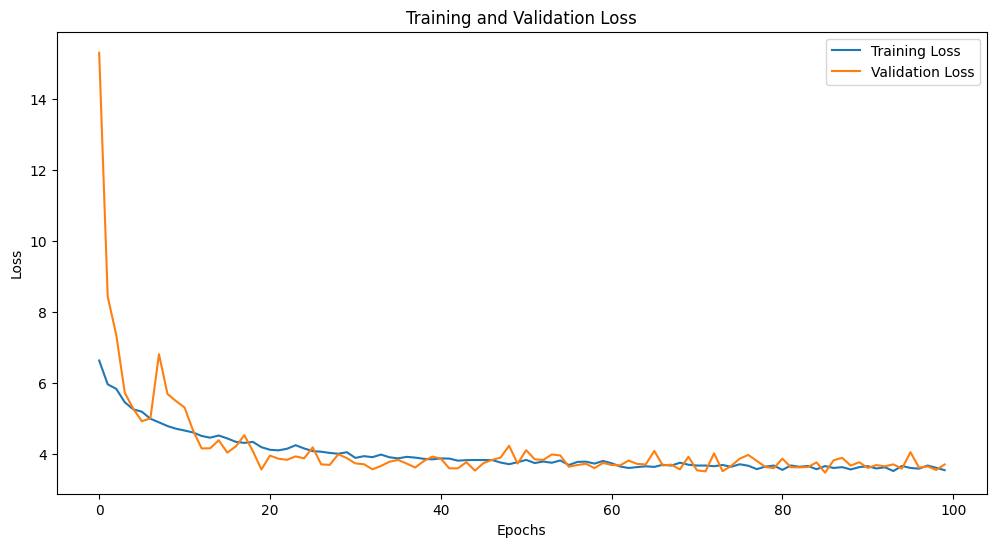

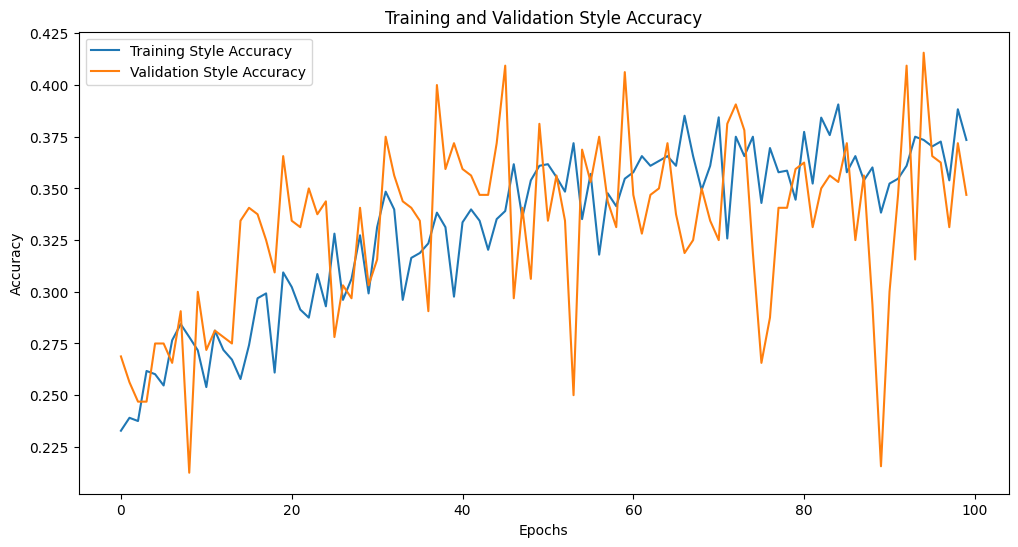

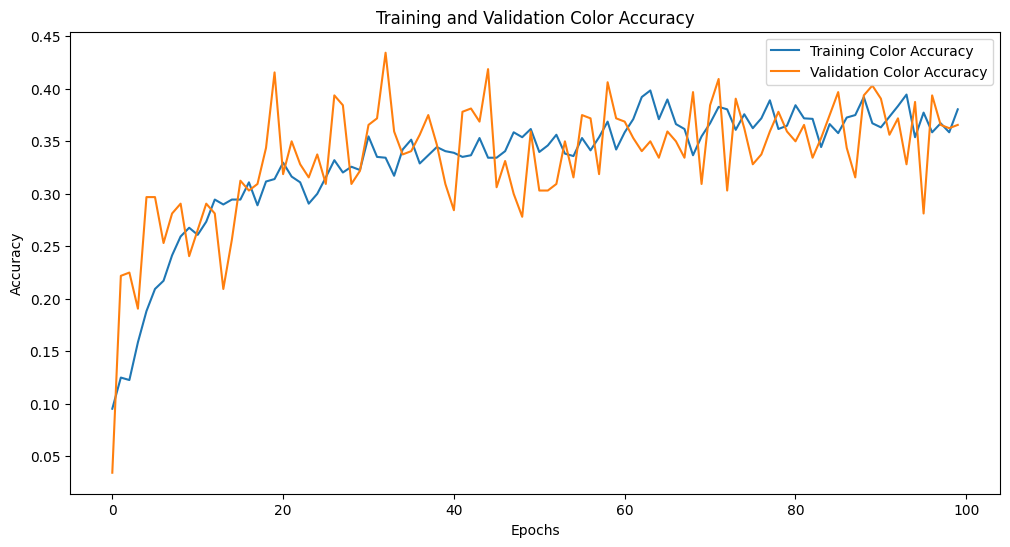

In [20]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)


##### trial 2 : resNet 벡본, 출력 레이어에서 추가 head 생성

In [21]:
resnet_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
resnet_model.trainable = False

# resnet_model + add.layer
x = resnet_model.get_layer('conv5_block3_out').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(resnet_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_RESNET_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history2=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_RESNET_2.h5')

<ipython-input-21-00ec1edfcba4>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model.fit_generator(training_set,


Epoch 1/100
20/19 [===============================] - ETA: 0s - loss: 6.6209 - style_loss: 2.4790 - color_loss: 4.1419 - style_accuracy: 0.2398 - color_accuracy: 0.0852
Epoch 1: val_loss improved from inf to 17.99529, saving model to feature_extraction_RESNET_2.h5
19/19 [==============================] - 12s 364ms/step - loss: 6.6209 - style_loss: 2.4790 - color_loss: 4.1419 - style_accuracy: 0.2398 - color_accuracy: 0.0852 - val_loss: 17.9953 - val_style_loss: 5.6076 - val_color_loss: 12.3877 - val_style_accuracy: 0.2937 - val_color_accuracy: 0.0875
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 6.1672 - style_loss: 2.2856 - color_loss: 3.8816 - style_accuracy: 0.2258 - color_accuracy: 0.0773
Epoch 2: val_loss improved from 17.99529 to 11.95731, saving model to feature_extraction_RESNET_2.h5
19/19 [==============================] - 6s 313ms/step - loss: 6.1672 - style_loss: 2.2856 - color_loss: 3.8816 - style_accuracy: 0.2258 - color_accuracy: 0.0773 - val_loss:

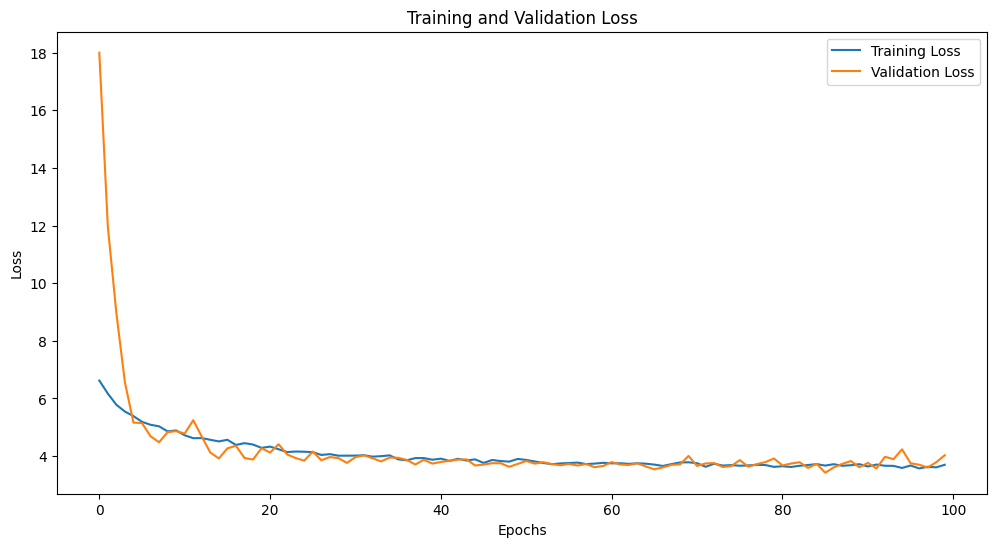

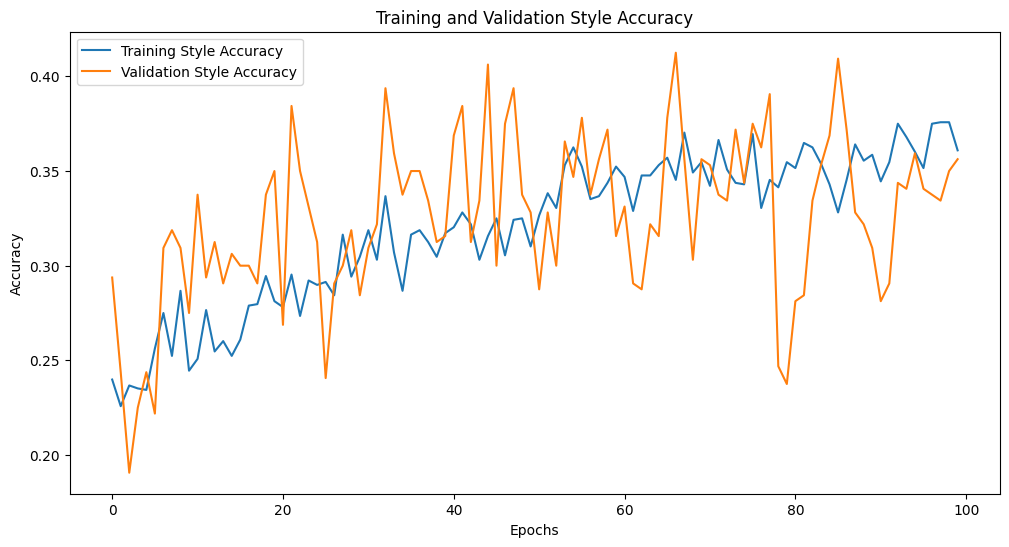

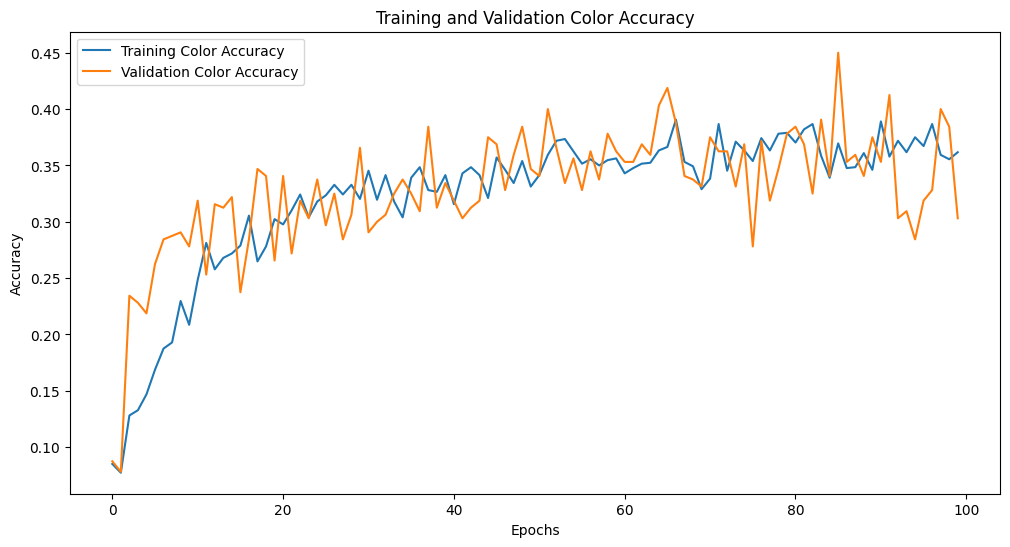

In [22]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history2)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history2)

# 색상 예측 정확도 시각화
plot_color_accuracy(history2)


##### trial 3 : VGG 벡본, MLP부터 추가 head 생성

In [23]:
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
# vgg_model.summary()

# vgg_model + add.layer
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)

branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)


branch_b=layers.Dense(units=256)(x)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Activation('relu')(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)
branch_b=layers.Dense(units=128)(branch_b)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)


style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_b)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_vgg_1.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history3=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_vgg_1.h5')

Epoch 1/100


<ipython-input-23-c714db5478ba>:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 4.0218 - color_loss: 4.0218 - style_accuracy: 0.1773 - color_accuracy: 0.1148
Epoch 1: val_loss improved from inf to 5.39236, saving model to feature_extraction_vgg_1.h5
19/19 [==============================] - 9s 373ms/step - loss: 4.0218 - color_loss: 4.0218 - style_accuracy: 0.1773 - color_accuracy: 0.1148 - val_loss: 5.3924 - val_color_loss: 5.3924 - val_style_accuracy: 0.1688 - val_color_accuracy: 0.0938
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 3.4549 - color_loss: 3.4549 - style_accuracy: 0.2078 - color_accuracy: 0.1711
Epoch 2: val_loss improved from 5.39236 to 4.44354, saving model to feature_extraction_vgg_1.h5
19/19 [==============================] - 7s 360ms/step - loss: 3.4549 - color_loss: 3.4549 - style_accuracy: 0.2078 - color_accuracy: 0.1711 - val_loss: 4.4435 - val_color_loss: 4.4435 - val_style_accuracy: 0.1813 - val_color_accuracy: 0.1562
Epoch 3/100
20/19 [=======================

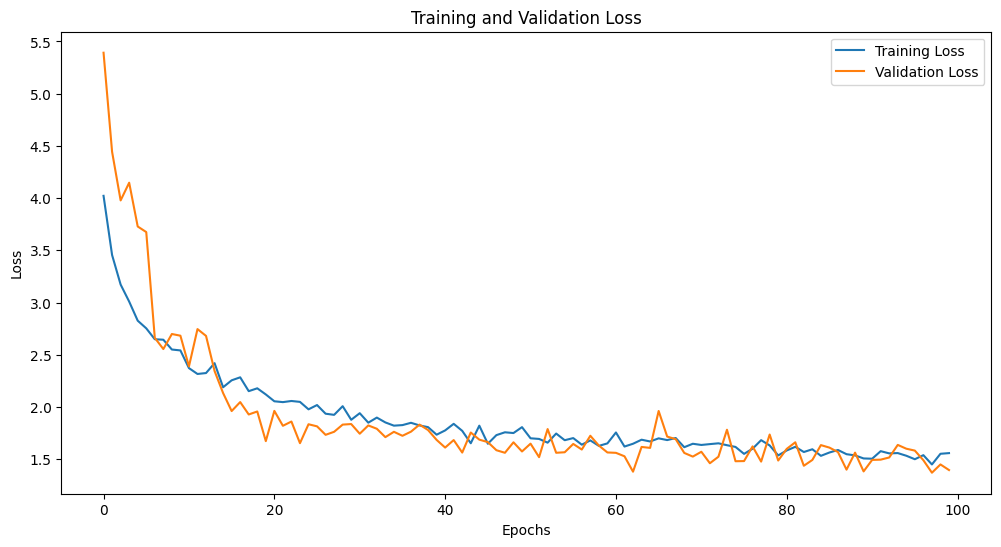

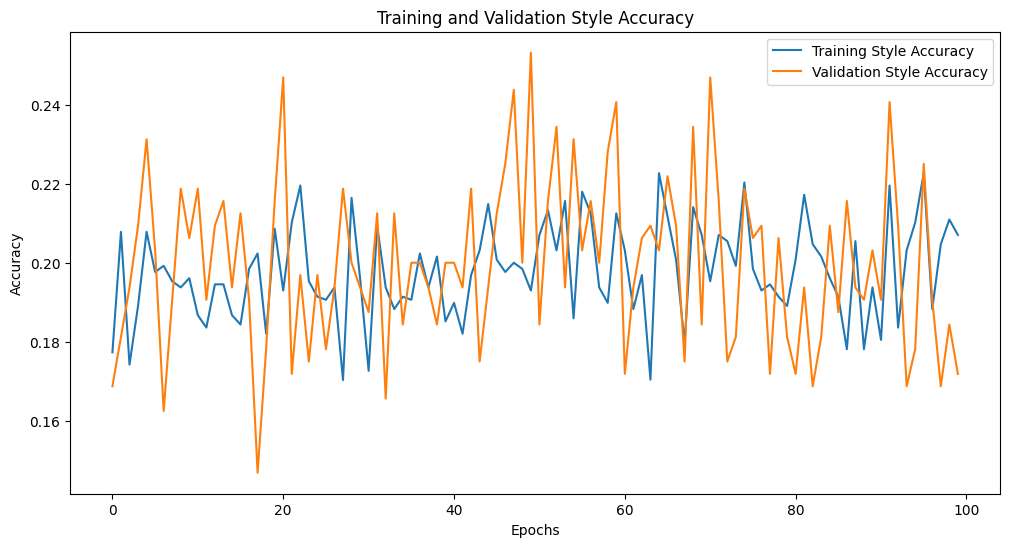

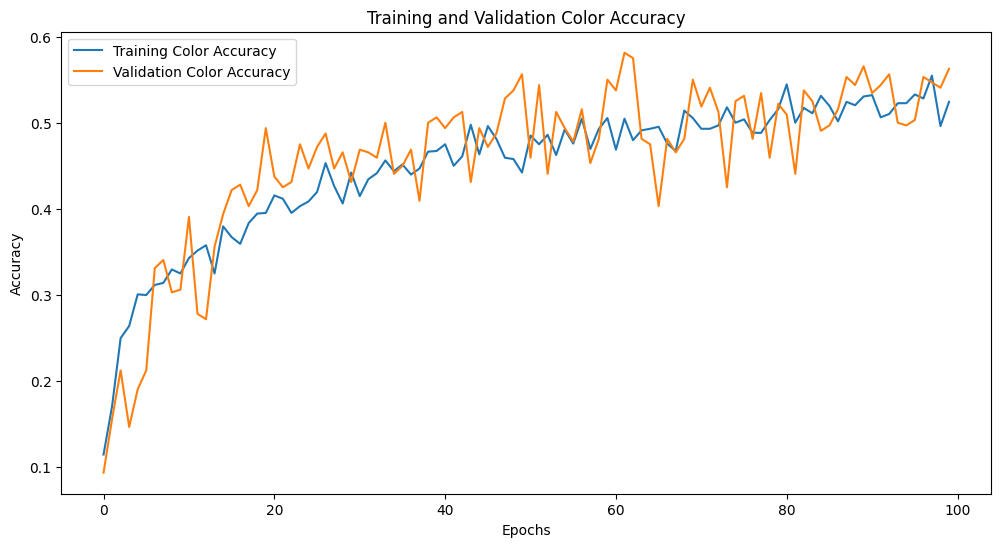

In [24]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history3)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history3)

# 색상 예측 정확도 시각화
plot_color_accuracy(history3)


##### trial 4 : VGG 벡본, 출력 레이어에서 추가 head 생성

In [25]:
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
# vgg_model + add.layer
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history4=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_VGG_2.h5')

Epoch 1/100


<ipython-input-25-41ed10a76bba>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 6.3921 - style_loss: 2.3172 - color_loss: 4.0750 - style_accuracy: 0.2719 - color_accuracy: 0.0766
Epoch 1: val_loss improved from inf to 7.61567, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 9s 373ms/step - loss: 6.3921 - style_loss: 2.3172 - color_loss: 4.0750 - style_accuracy: 0.2719 - color_accuracy: 0.0766 - val_loss: 7.6157 - val_style_loss: 3.1847 - val_color_loss: 4.4309 - val_style_accuracy: 0.2719 - val_color_accuracy: 0.1344
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 5.8603 - style_loss: 2.1661 - color_loss: 3.6942 - style_accuracy: 0.2672 - color_accuracy: 0.1195
Epoch 2: val_loss improved from 7.61567 to 4.92643, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 7s 345ms/step - loss: 5.8603 - style_loss: 2.1661 - color_loss: 3.6942 - style_accuracy: 0.2672 - color_accuracy: 0.1195 - val_loss: 4.9264 - val_style_loss

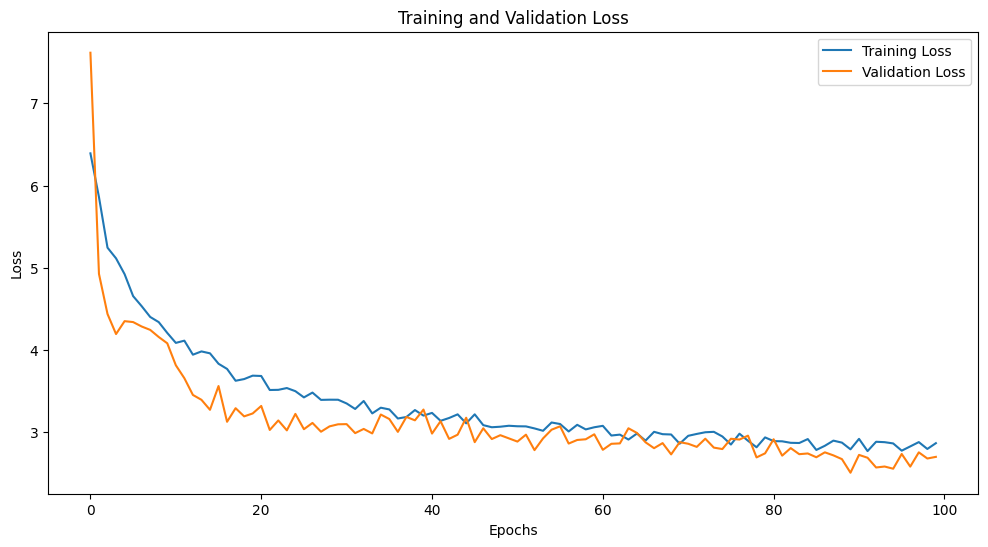

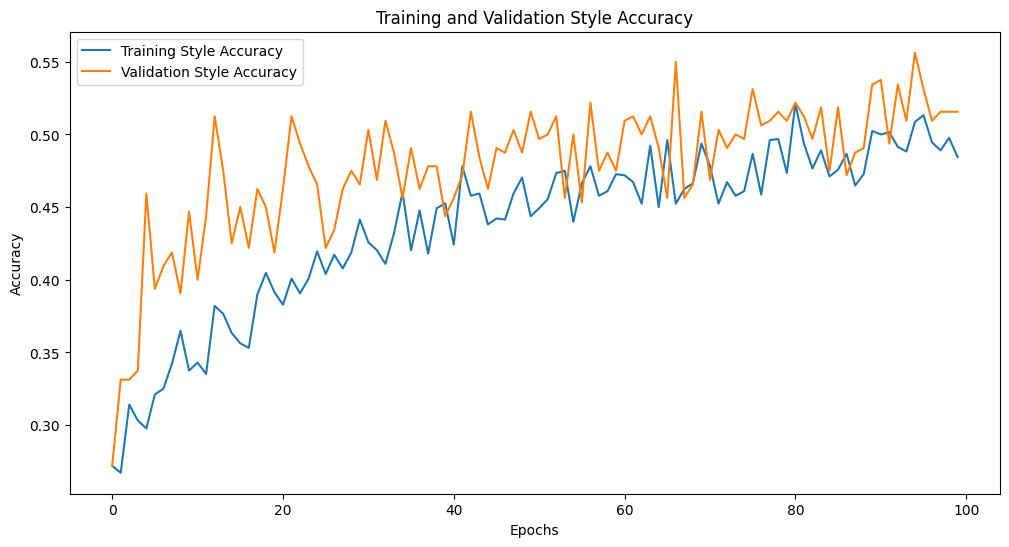

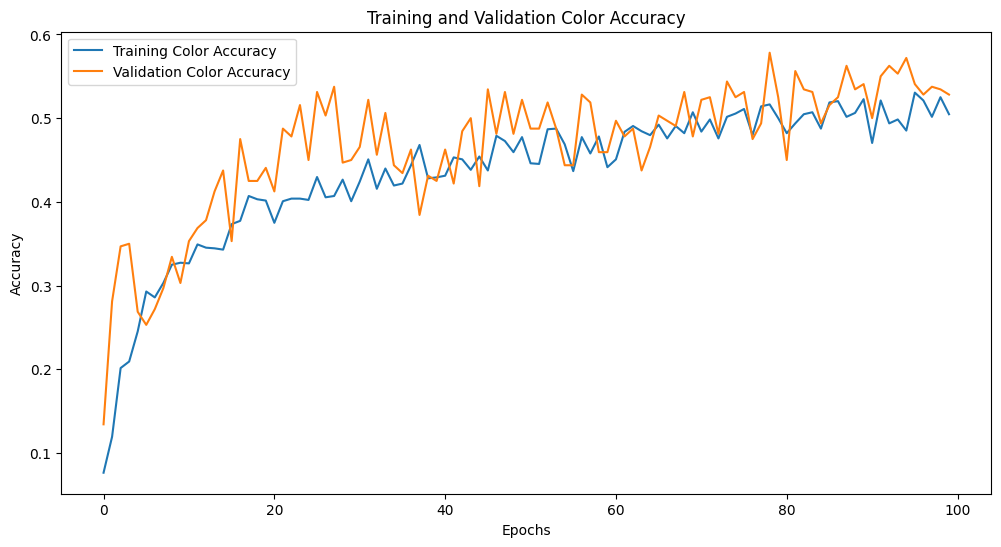

In [26]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history4)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history4)

# 색상 예측 정확도 시각화
plot_color_accuracy(history4)

### optimizer

*   Nadam, AdamW, Adam 비교, Nadam에서 성능이 제일 좋음



In [14]:
# AdamW 사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=AdamW(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-14-4919776a4118>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
20/19 [===============================] - ETA: 0s - loss: 6.9195 - style_loss: 2.8233 - color_loss: 4.0962 - style_accuracy: 0.1844 - color_accuracy: 0.0812
Epoch 1: val_loss improved from inf to 5.37154, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 10s 360ms/step - loss: 6.9195 - style_loss: 2.8233 - color_loss: 4.0962 - style_accuracy: 0.1844 - color_accuracy: 0.0812 - val_loss: 5.3715 - val_style_loss: 2.1313 - val_color_loss: 3.2403 - val_style_accuracy: 0.2094 - val_color_accuracy: 0.0844
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 6.2905 - style_loss: 2.5476 - color_loss: 3.7429 - style_accuracy: 0.2281 - color_accuracy: 0.1500
Epoch 2: val_loss improved from 5.37154 to 4.70296, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 6s 334ms/step - loss: 6.2905 - style_loss: 2.5476 - color_loss: 3.7429 - style_accuracy: 0.2281 - color_accuracy: 0.1500 - val_loss: 4.7030 - val_style_loss: 1.7497 - val_color_loss: 2.9532 - val_style_accuracy: 0.3625 - val_color_accuracy: 0.2469
Epoch 3/100
20/19 [===============================] - ETA: 0s - loss: 5.9530 - style_loss: 2.4300 - color_loss: 3.5230 - style_accuracy: 0.2453 - color_accu

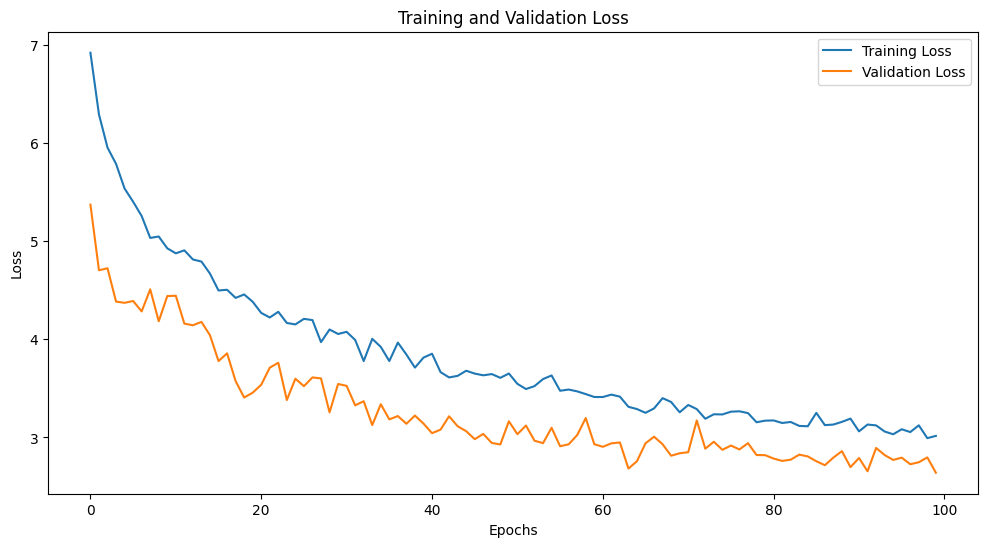

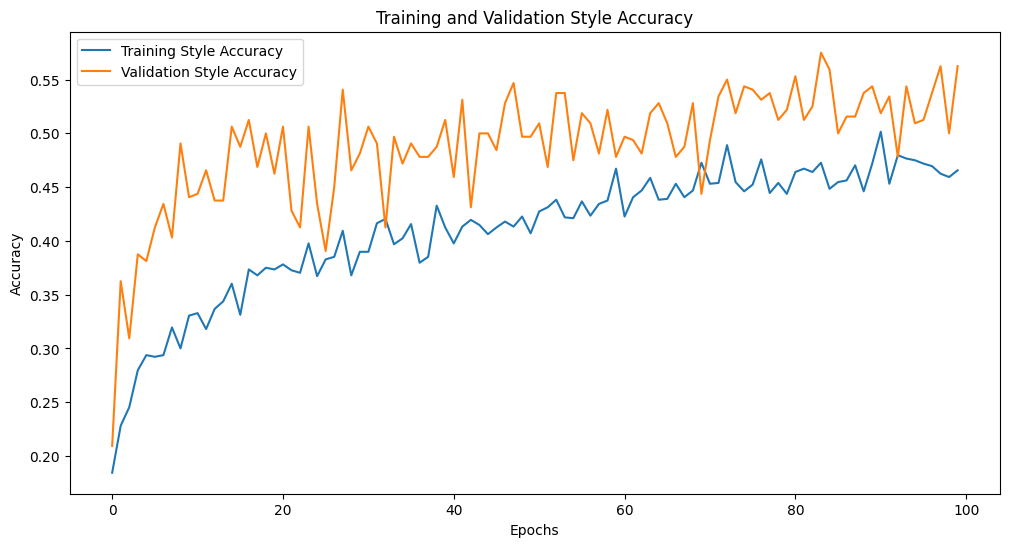

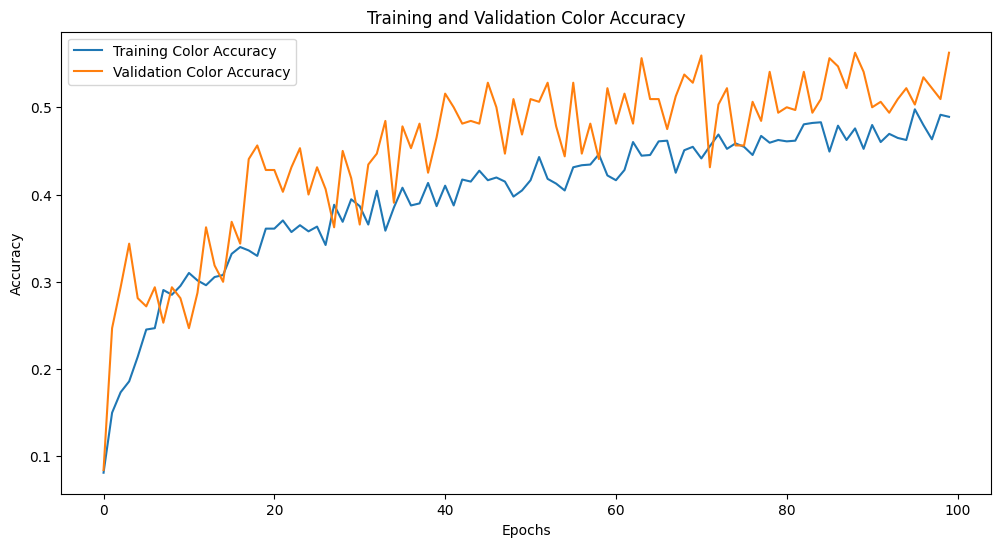

In [15]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [16]:
# Nadam 사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Nadam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

Epoch 1/100


<ipython-input-16-0db558e6e44d>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 6.9864 - style_loss: 2.8510 - color_loss: 4.1353 - style_accuracy: 0.1844 - color_accuracy: 0.0750
Epoch 1: val_loss improved from inf to 5.38659, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 11s 370ms/step - loss: 6.9864 - style_loss: 2.8510 - color_loss: 4.1353 - style_accuracy: 0.1844 - color_accuracy: 0.0750 - val_loss: 5.3866 - val_style_loss: 1.8937 - val_color_loss: 3.4929 - val_style_accuracy: 0.1969 - val_color_accuracy: 0.1187
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 6.4702 - style_loss: 2.6136 - color_loss: 3.8567 - style_accuracy: 0.2117 - color_accuracy: 0.1273
Epoch 2: val_loss improved from 5.38659 to 5.14560, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 7s 343ms/step - loss: 6.4702 - style_loss: 2.6136 - color_loss: 3.8567 - style_accuracy: 0.2117 - color_accuracy: 0.1273 - val_loss: 5.1456 - val_style_los

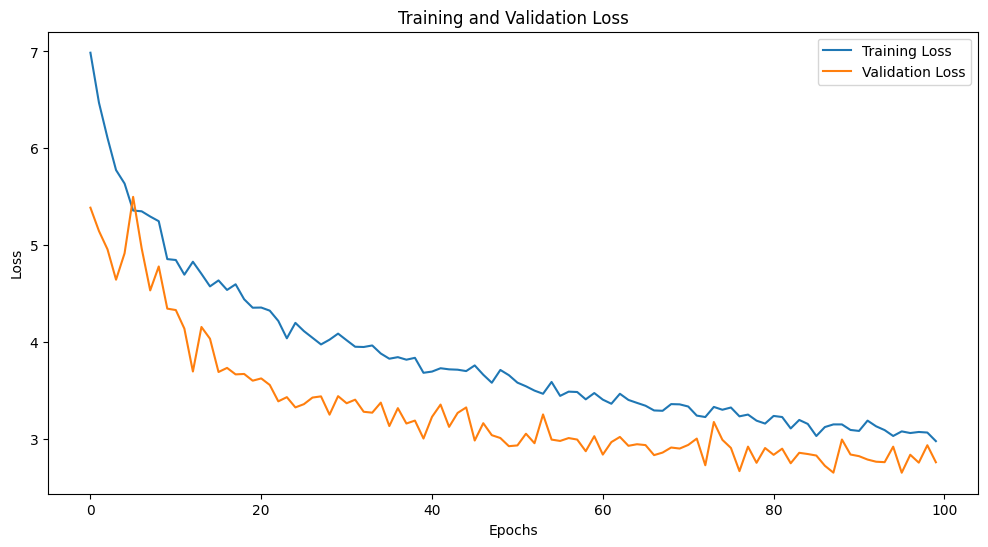

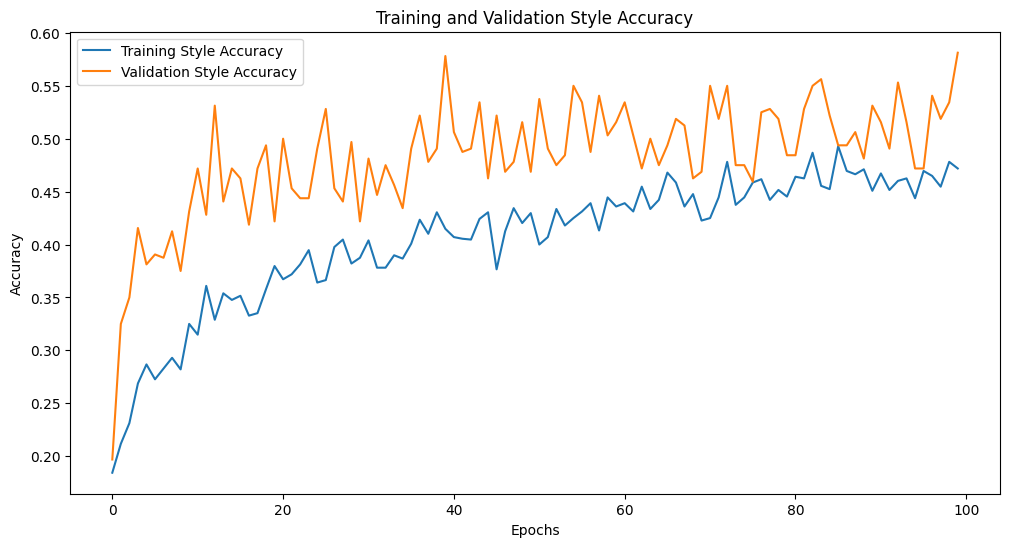

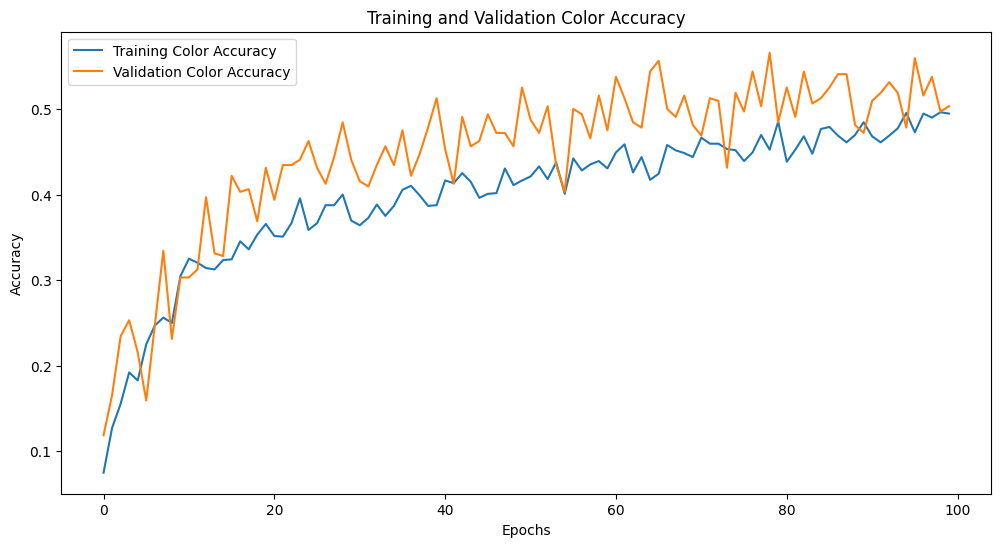

In [17]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### epoch



*   EarlyStopping을 사용한 경우와 사용하지 않은 경우를 비교, EarlyStopping으로 인해서 아직 모델이 학습이 되지 않았을 때 멈출 가능성을 확인
*   earlystoping 사용한 경우 80에폭에서 정지, earlystoping을 사용하지 않은 경우에도 80에폭 언저리에서 수렴하므로 earlystoping을 쓰는 것이 합리적





In [ ]:
# early stopping 사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, early_stopping_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

Epoch 1/100


<ipython-input-35-3aba2888d22c>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 7.3285 - style_loss: 3.0017 - color_loss: 4.3268 - style_accuracy: 0.1667 - color_accuracy: 0.0573
Epoch 1: val_loss improved from inf to 6.14834, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 8s 261ms/step - loss: 7.3285 - style_loss: 3.0017 - color_loss: 4.3268 - style_accuracy: 0.1667 - color_accuracy: 0.0573 - val_loss: 6.1483 - val_style_loss: 2.3978 - val_color_loss: 3.7505 - val_style_accuracy: 0.1927 - val_color_accuracy: 0.0312
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.6831 - style_loss: 2.7348 - color_loss: 3.9483 - style_accuracy: 0.2083 - color_accuracy: 0.1263
Epoch 2: val_loss improved from 6.14834 to 5.39836, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 5s 215ms/step - loss: 6.6831 - style_loss: 2.7348 - color_loss: 3.9483 - style_accuracy: 0.2083 - color_accuracy: 0.1263 - val_loss: 5.3984 - val_style_loss: 2.1318 - val_color_loss: 3.2666 - val_style_accuracy: 0.2812 - val_color_accuracy: 0.0729
Epoch 3/100
24/23 [==============================] - ETA: 0s - loss: 6.4126 - style_loss: 2.6168 - color_loss: 3.7959 - style_accuracy: 0.1849 - color_accurac

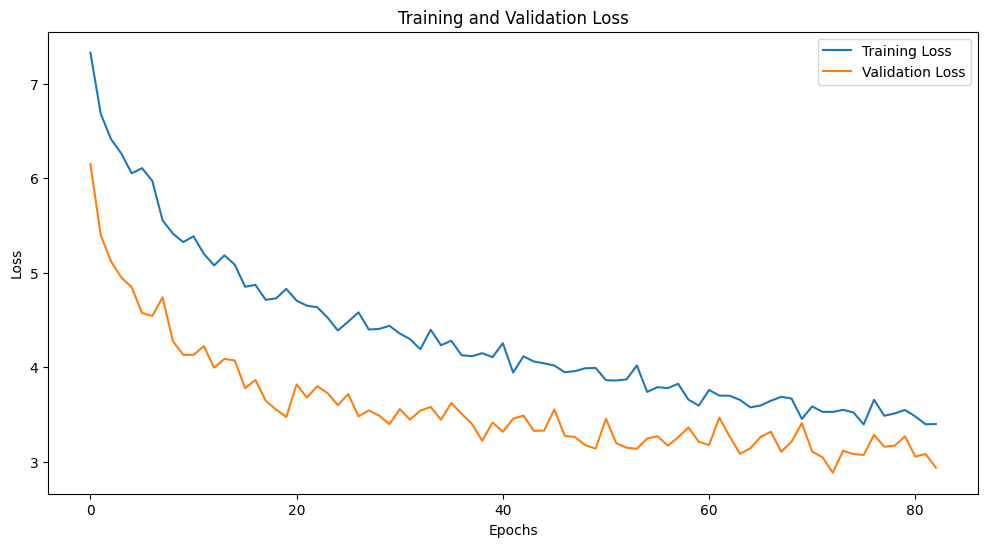

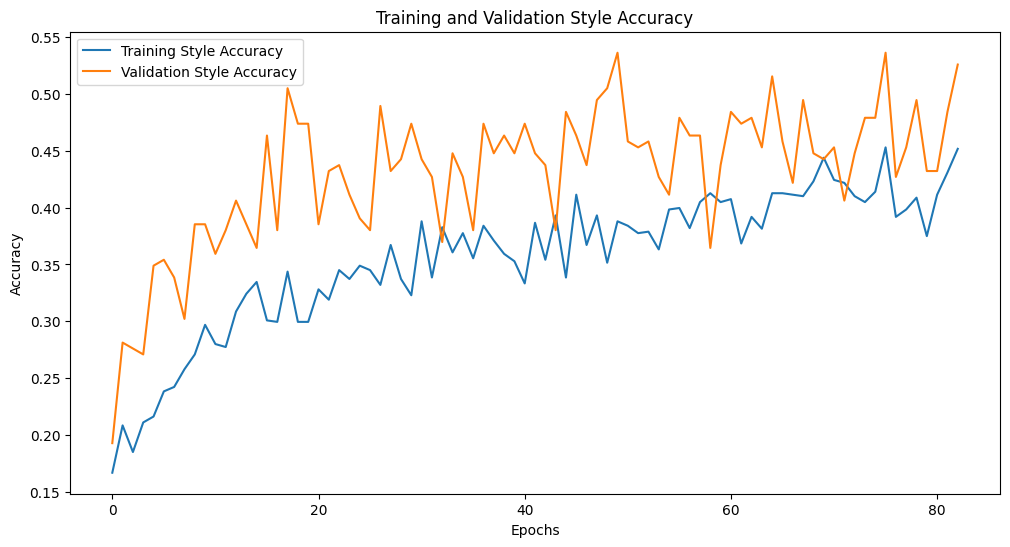

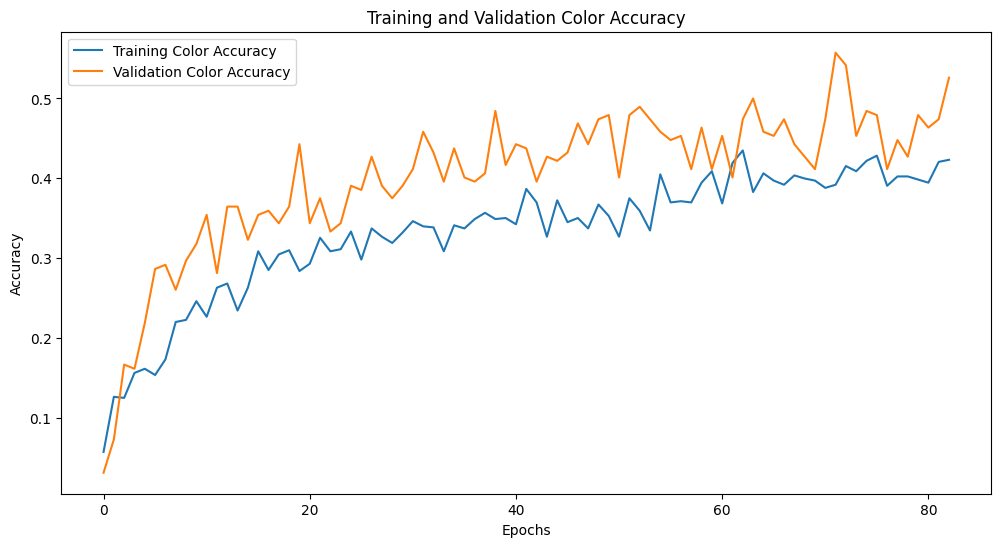

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# early stopping 사용 x

vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParameter_noEarlyStop.h5')

Epoch 1/100


<ipython-input-14-ea64a94d5839>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 6.9759 - style_loss: 2.8181 - color_loss: 4.1578 - style_accuracy: 0.1771 - color_accuracy: 0.0924
Epoch 1: val_loss improved from inf to 5.57922, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 9s 236ms/step - loss: 6.9759 - style_loss: 2.8181 - color_loss: 4.1578 - style_accuracy: 0.1771 - color_accuracy: 0.0924 - val_loss: 5.5792 - val_style_loss: 2.2254 - val_color_loss: 3.3538 - val_style_accuracy: 0.1979 - val_color_accuracy: 0.1875
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.5408 - style_loss: 2.7576 - color_loss: 3.7833 - style_accuracy: 0.1901 - color_accuracy: 0.1185
Epoch 2: val_loss improved from 5.57922 to 4.86981, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 6s 244ms/step - loss: 6.5408 - style_loss: 2.7576 - color_loss: 3.7833 - style_accuracy: 0.1901 - color_accuracy: 0.1185 - val_loss: 4.8698 - val_style_loss: 

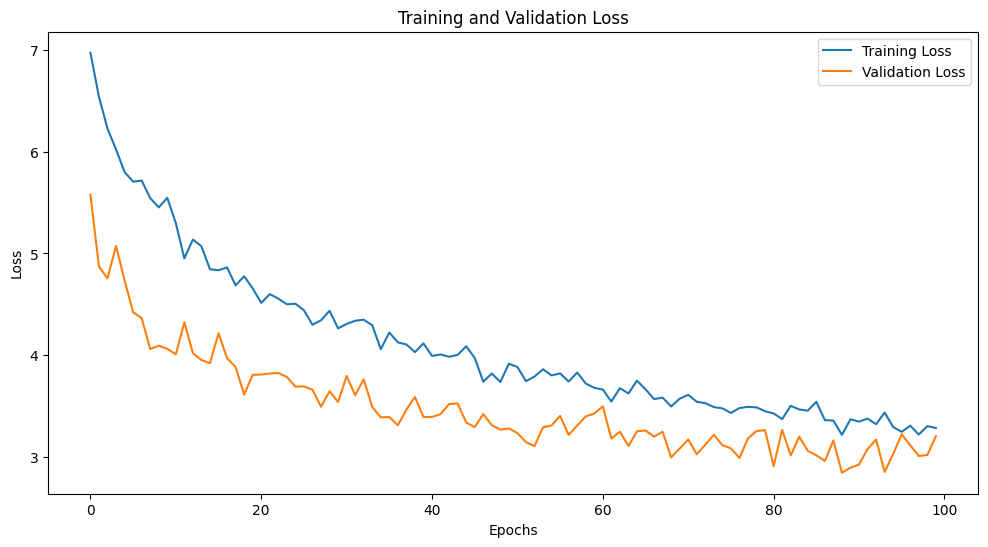

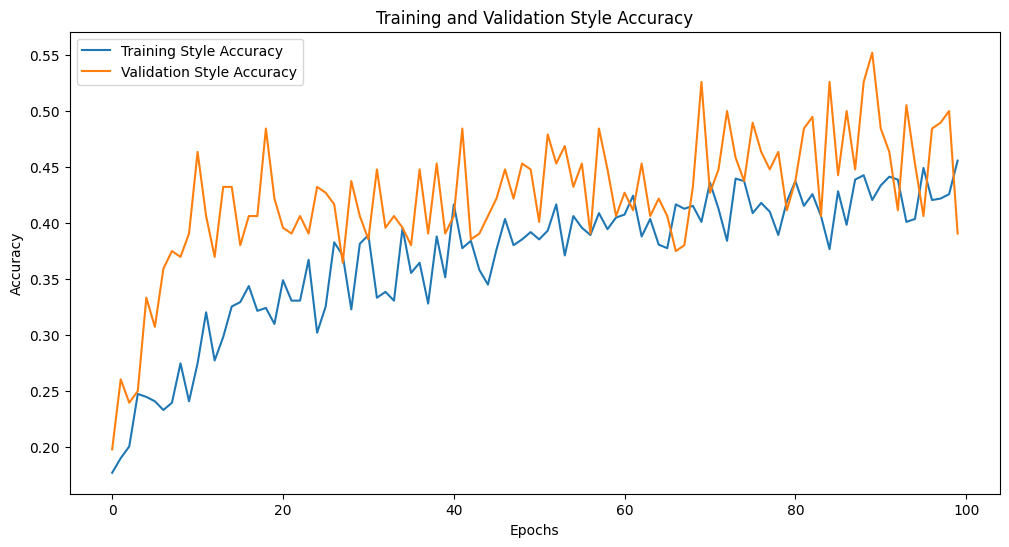

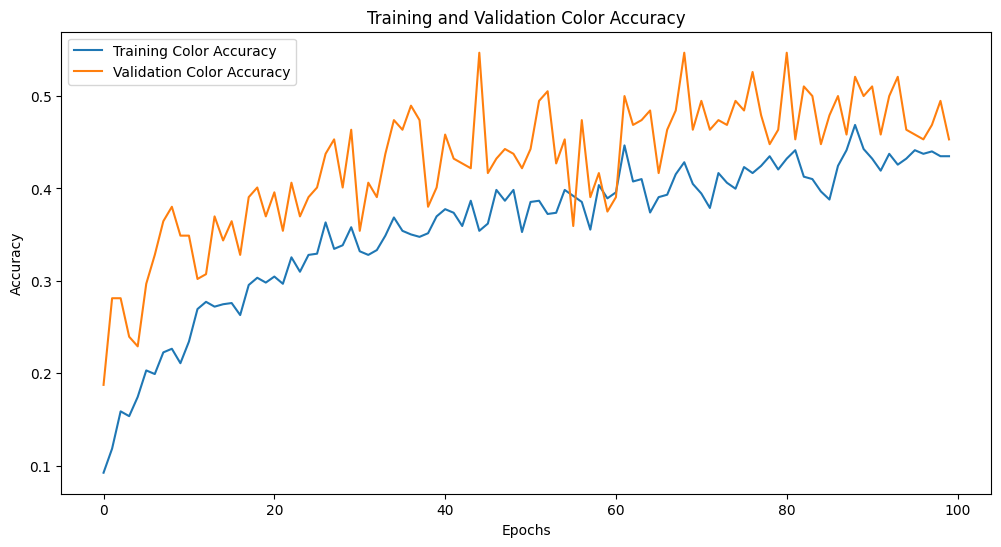

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### finetune vs end to end


*   pretrain에 비해서 성능이 상당히 낮음
*   비교적 성능을 확인하려면 입력 데이터를 추가해야 함, 하지만 리소스를 너무 많이 잡아먹음



In [ ]:
# finetune : 앞에 6개 레이어는 고정, 뒤에 나머지 7개 학습
# 코드는 없지만 학습 시키는 layer 수를 줄여봤지만 크게 의미가 없음, 학습시키는 레이어를 크게 하는 건 end to end와 다를 게 없으므로 안해 봄
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = True

for layer in vgg_model.layers[:7]:
  layer.trainable = False

x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParameter_noEarlyStop.h5')

Epoch 1/100


<ipython-input-26-e0f0acd7d5db>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 7.4063 - style_loss: 3.0573 - color_loss: 4.3489 - style_accuracy: 0.1528 - color_accuracy: 0.0563
Epoch 1: val_loss improved from inf to 91.76324, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 17s 582ms/step - loss: 7.4063 - style_loss: 3.0573 - color_loss: 4.3489 - style_accuracy: 0.1528 - color_accuracy: 0.0563 - val_loss: 91.7632 - val_style_loss: 37.5464 - val_color_loss: 54.2168 - val_style_accuracy: 0.1875 - val_color_accuracy: 0.0260
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.9664 - style_loss: 2.8170 - color_loss: 4.1495 - style_accuracy: 0.1667 - color_accuracy: 0.0716
Epoch 2: val_loss improved from 91.76324 to 81.26669, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 10s 408ms/step - loss: 6.9664 - style_loss: 2.8170 - color_loss: 4.1495 - style_accuracy: 0.1667 - color_accuracy: 0.0716 - val_loss: 81.2667 - val_style_loss: 54.5556 - val_color_loss: 26.7111 - val_style_accuracy: 0.1667 - val_color_accuracy: 0.0156
Epoch 3/100
24/23 [==============================] - ETA: 0s - loss: 6.4685 - style_loss: 2.5972 - color_loss: 3.8713 - style_accuracy: 0.1797 - col

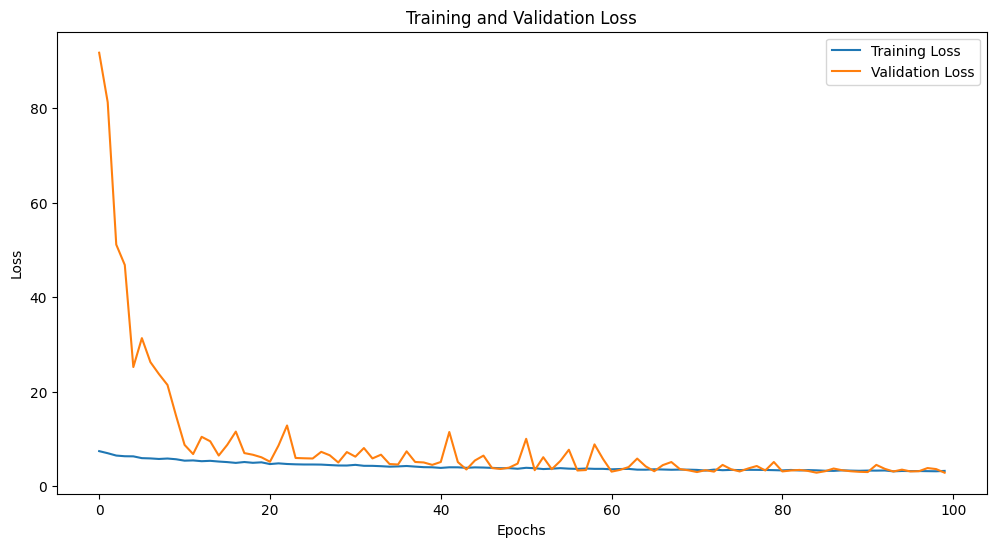

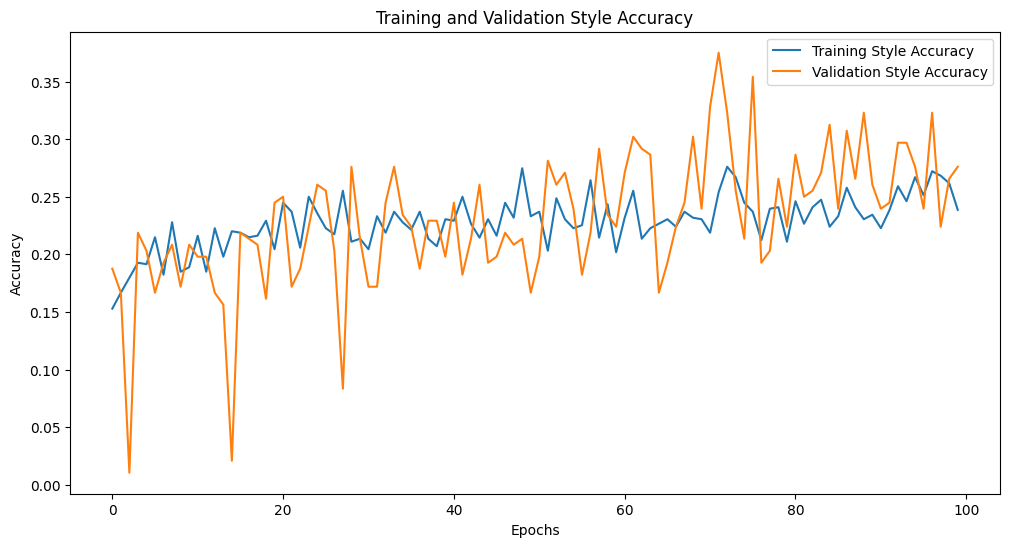

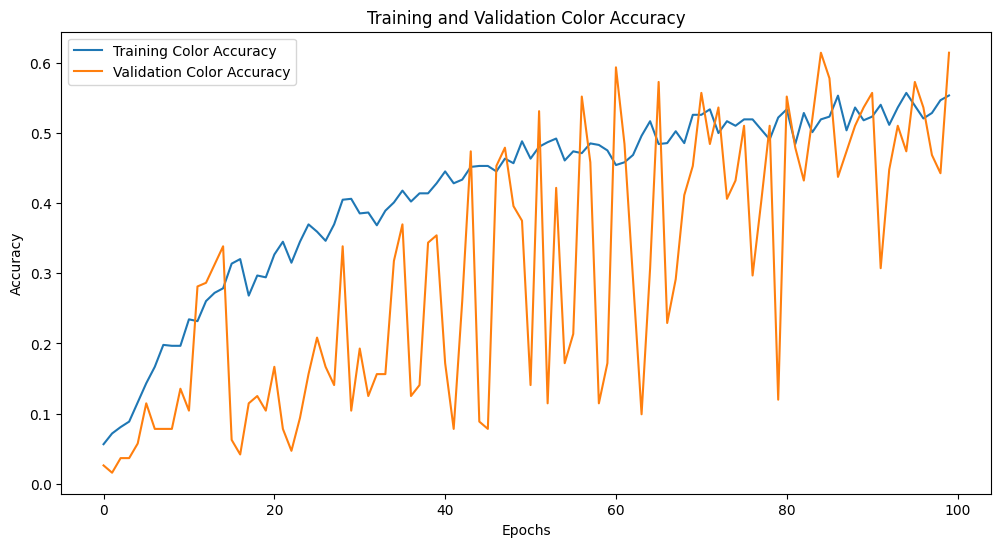

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# end to end
vgg_model = VGG16(weights=None, input_shape=(256,256,3), include_top=False)
vgg_model.trainable = True

x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParameter_noEarlyStop.h5')

Epoch 1/100


<ipython-input-28-c789d0d78672>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 5.3632 - style_loss: 2.1348 - color_loss: 3.2284 - style_accuracy: 0.1628 - color_accuracy: 0.0586
Epoch 1: val_loss improved from inf to 4.95417, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 18s 596ms/step - loss: 5.3632 - style_loss: 2.1348 - color_loss: 3.2284 - style_accuracy: 0.1628 - color_accuracy: 0.0586 - val_loss: 4.9542 - val_style_loss: 1.9372 - val_color_loss: 3.0170 - val_style_accuracy: 0.1823 - val_color_accuracy: 0.2708
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 4.9607 - style_loss: 1.9455 - color_loss: 3.0152 - style_accuracy: 0.1862 - color_accuracy: 0.1185
Epoch 2: val_loss improved from 4.95417 to 4.92528, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 14s 594ms/step - loss: 4.9607 - style_loss: 1.9455 - color_loss: 3.0152 - style_accuracy: 0.1862 - color_accuracy: 0.1185 - val_loss: 4.9253 - val_style_loss: 1.9196 - val_color_loss: 3.0057 - val_style_accuracy: 0.1927 - val_color_accuracy: 0.3021
Epoch 3/100
24/23 [==============================] - ETA: 0s - loss: 4.9111 - style_loss: 1.9170 - color_loss: 2.9941 - style_accuracy: 0.1810 - color_accur

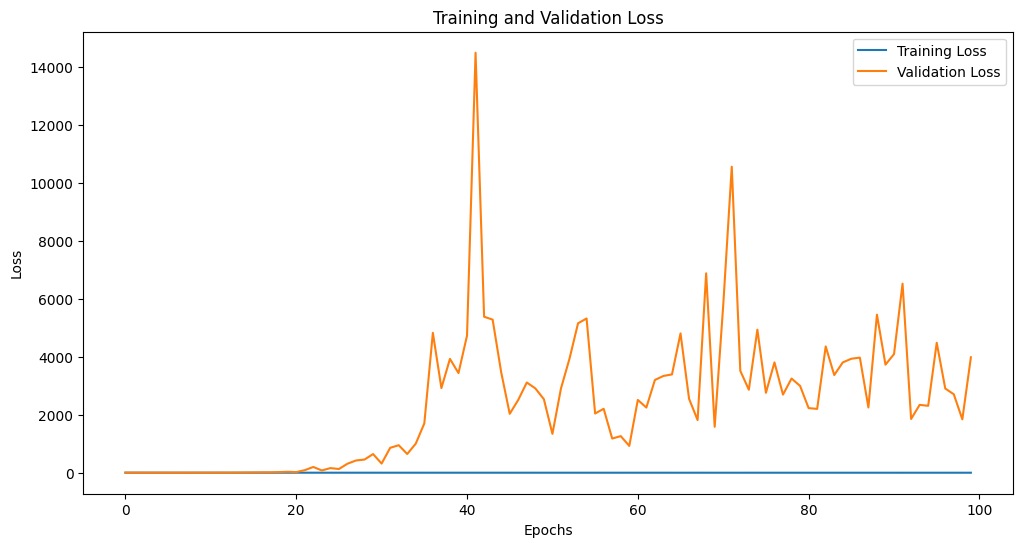

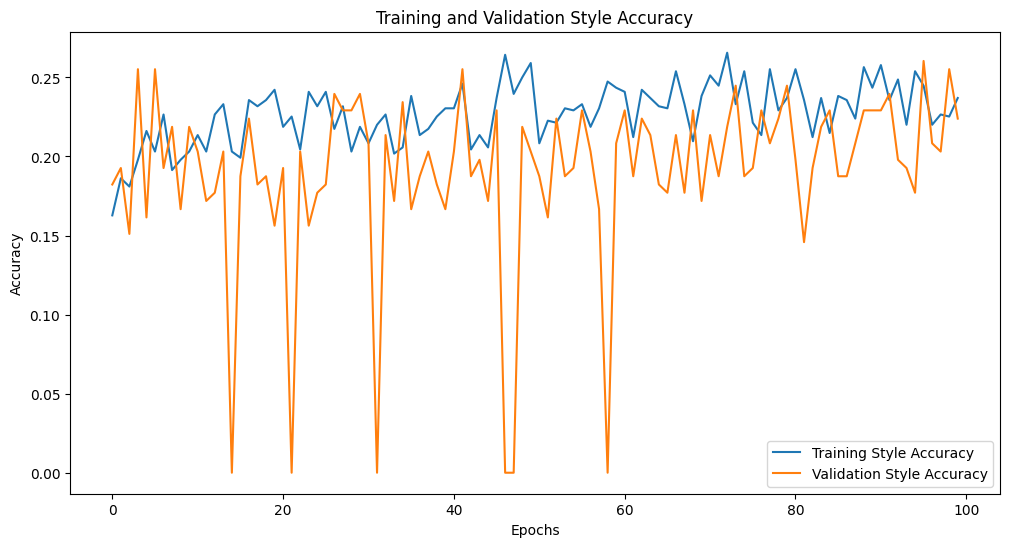

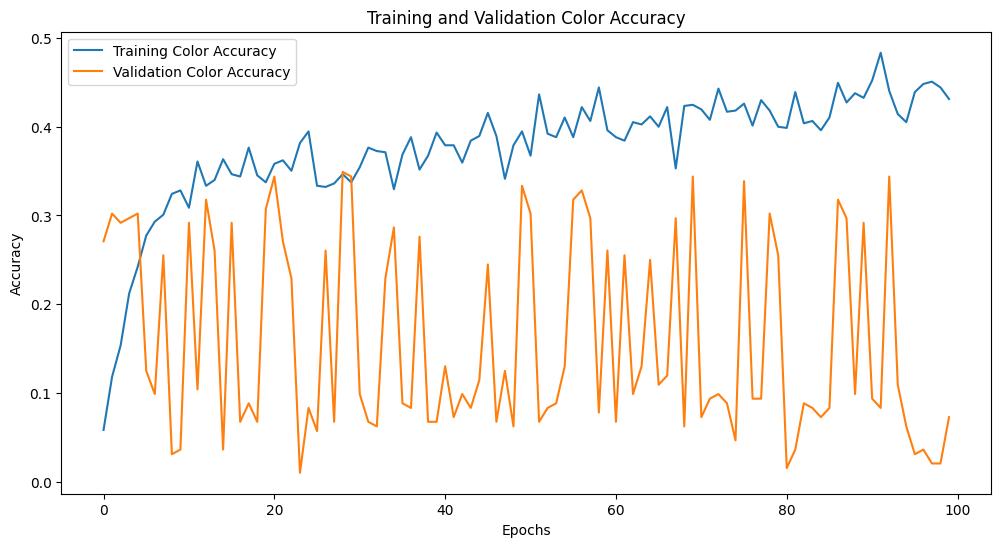

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### learning_rate


*   고정된 학습률 : 0.01, 0.001, 0.0001, 3e-4
*   reduce_learning_rate(상한 : 0.1, 하한 : 0), reduce_learning_rate(상한 : 0.1, 하한 : 3e-5)


---



*   총 6가지의 경우의 수를 비교
*   고정된 3e-4를 사용할 때 성능이 가장 높았음





In [ ]:
# 학습률 초기값 0.01
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 0.01), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-7-14344ee740c2>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 6.9606 - style_loss: 2.7869 - color_loss: 4.1738 - style_accuracy: 0.1562 - color_accuracy: 0.0651
Epoch 1: val_loss improved from inf to 31.99216, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 24s 757ms/step - loss: 6.9606 - style_loss: 2.7869 - color_loss: 4.1738 - style_accuracy: 0.1562 - color_accuracy: 0.0651 - val_loss: 31.9922 - val_style_loss: 9.8286 - val_color_loss: 22.1635 - val_style_accuracy: 0.1797 - val_color_accuracy: 0.0234
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 6.2419 - style_loss: 2.6388 - color_loss: 3.6031 - style_accuracy: 0.1953 - color_accuracy: 0.1172
Epoch 2: val_loss improved from 31.99216 to 29.02209, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 3s 553ms/step - loss: 6.2419 - style_loss: 2.6388 - color_loss: 3.6031 - style_accuracy: 0.1953 - color_accuracy: 0.1172 - val_loss: 29.0221 - val_style_loss: 11.2273 - val_color_loss: 17.7948 - val_style_accuracy: 0.2109 - val_color_accuracy: 0.0234
Epoch 3/100
6/5 [==============================] - ETA: 0s - loss: 5.6285 - style_loss: 2.1901 - color_loss: 3.4385 - style_accuracy: 0.2031 - color_accurac

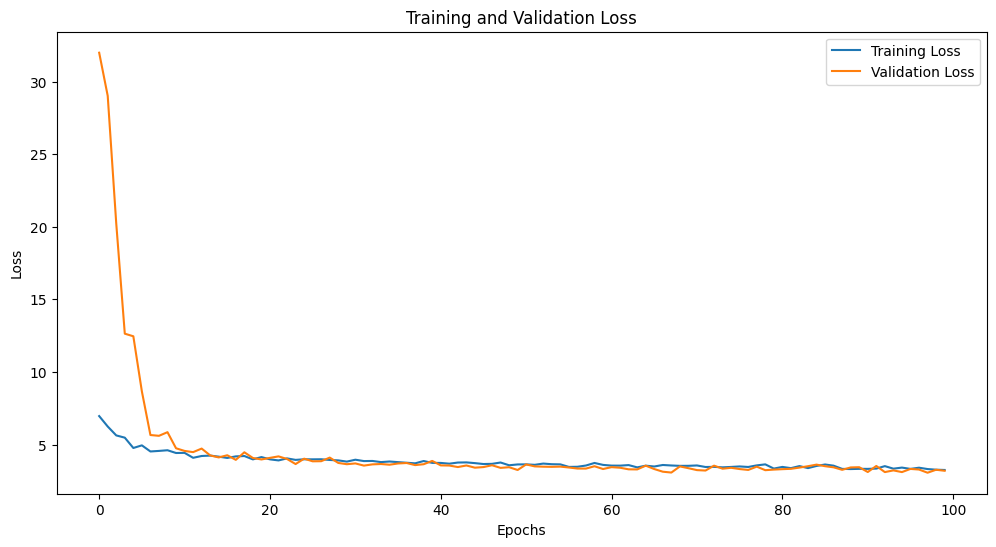

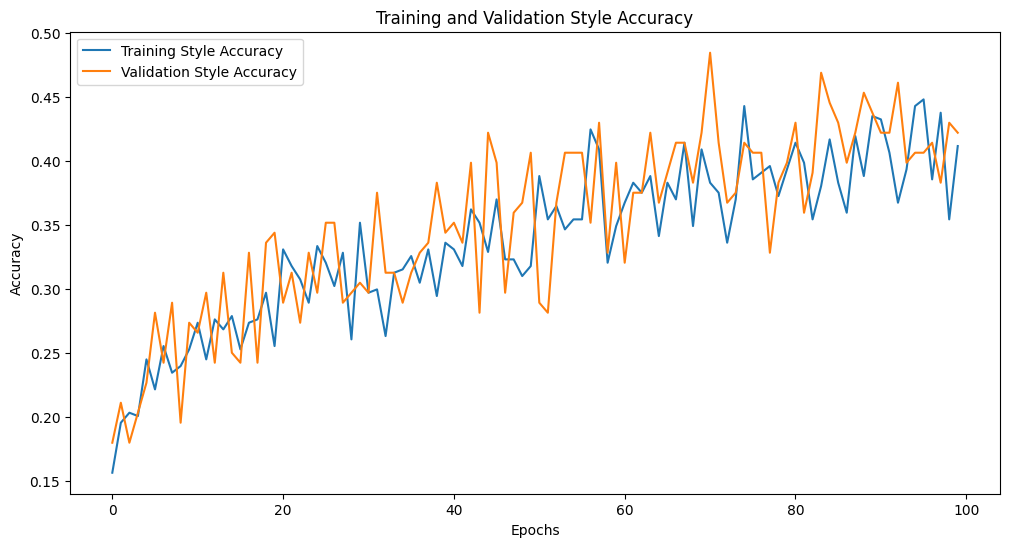

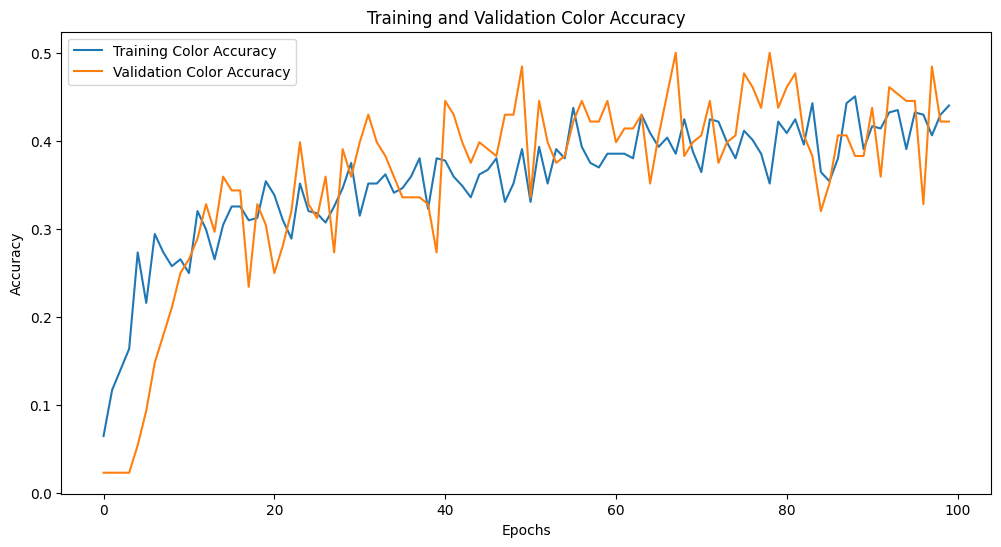

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# 학습률 초기값 0.001
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 0.001), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-9-b7347cc19625>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 7.1354 - style_loss: 2.8779 - color_loss: 4.2575 - style_accuracy: 0.1693 - color_accuracy: 0.0573
Epoch 1: val_loss improved from inf to 7.35846, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 6s 770ms/step - loss: 7.1354 - style_loss: 2.8779 - color_loss: 4.2575 - style_accuracy: 0.1693 - color_accuracy: 0.0573 - val_loss: 7.3585 - val_style_loss: 2.8800 - val_color_loss: 4.4785 - val_style_accuracy: 0.2109 - val_color_accuracy: 0.2656
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 6.6109 - style_loss: 2.6230 - color_loss: 3.9879 - style_accuracy: 0.2083 - color_accuracy: 0.0885
Epoch 2: val_loss did not improve from 7.35846
5/5 [==============================] - 3s 580ms/step - loss: 6.6109 - style_loss: 2.6230 - color_loss: 3.9879 - style_accuracy: 0.2083 - color_accuracy: 0.0885 - val_loss: 8.3269 - val_style_loss: 3.9877 - val_color_loss: 4.3391 - val_style_a

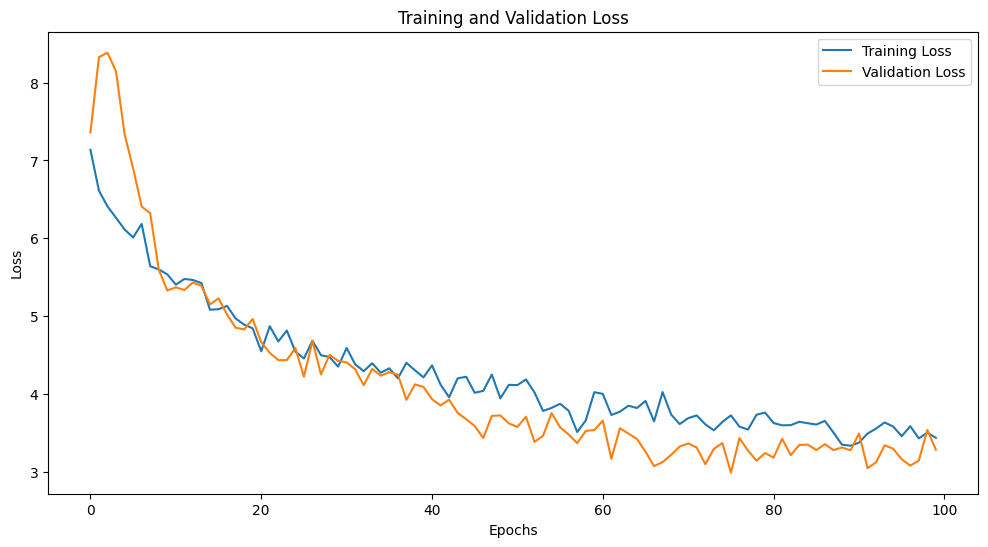

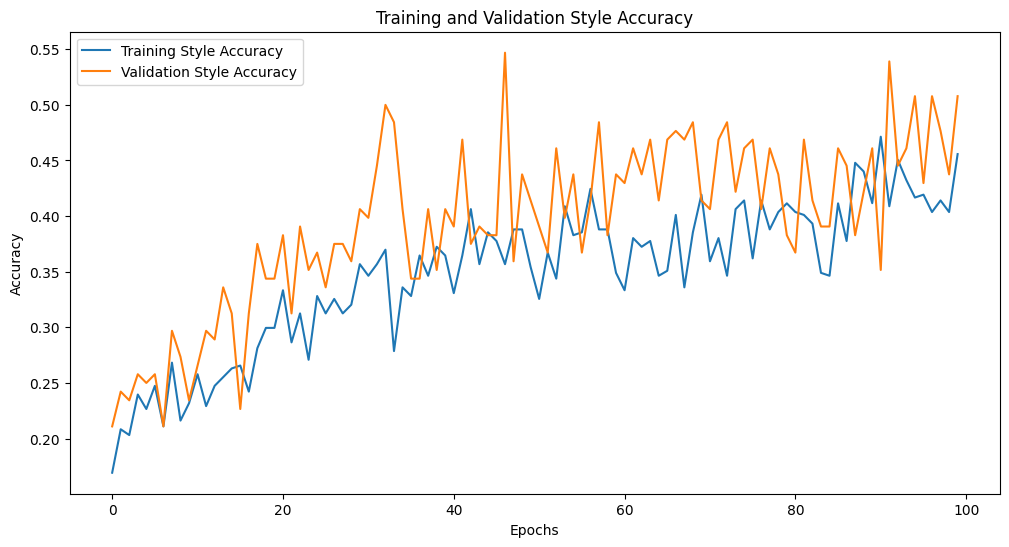

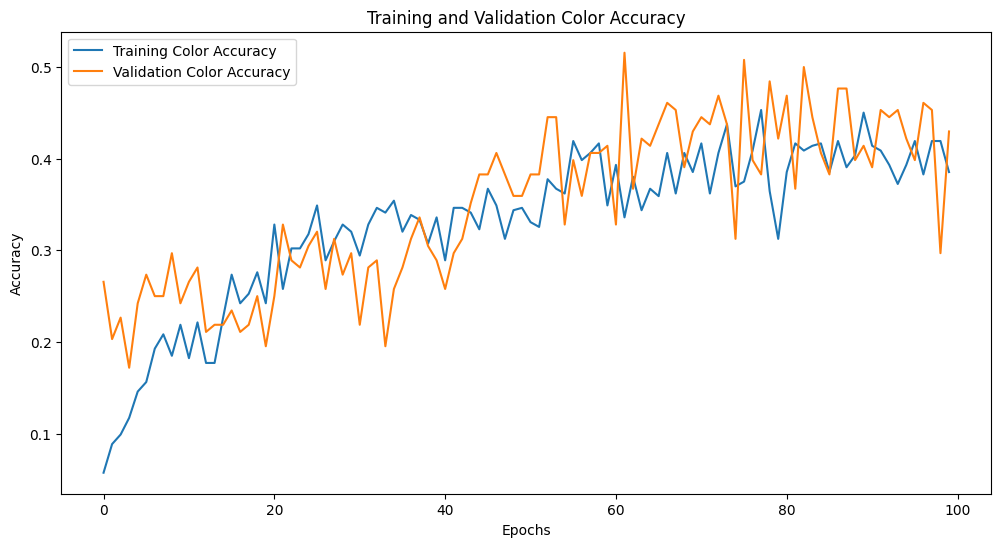

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# 학습률 초기값 0.0001
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 0.0001), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-13-66989da0e7ca>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 7.4728 - style_loss: 2.9664 - color_loss: 4.5064 - style_accuracy: 0.1797 - color_accuracy: 0.0339
Epoch 1: val_loss improved from inf to 5.52347, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 7s 726ms/step - loss: 7.4728 - style_loss: 2.9664 - color_loss: 4.5064 - style_accuracy: 0.1797 - color_accuracy: 0.0339 - val_loss: 5.5235 - val_style_loss: 2.3308 - val_color_loss: 3.1926 - val_style_accuracy: 0.0156 - val_color_accuracy: 0.0625
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 7.3123 - style_loss: 3.0793 - color_loss: 4.2330 - style_accuracy: 0.2005 - color_accuracy: 0.0521
Epoch 2: val_loss improved from 5.52347 to 5.45679, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 4s 661ms/step - loss: 7.3123 - style_loss: 3.0793 - color_loss: 4.2330 - style_accuracy: 0.2005 - color_accuracy: 0.0521 - val_loss: 5.4568 - val_style_loss: 2.2243 - val_color_loss: 3.2325 - val_style_accuracy: 0.0625 - val_color_accuracy: 0.0469
Epoch 3/100
6/5 [==============================] - ETA: 0s - loss: 7.2763 - style_loss: 2.9544 - color_loss: 4.3219 - style_accuracy: 0.1953 - color_accuracy: 0.067

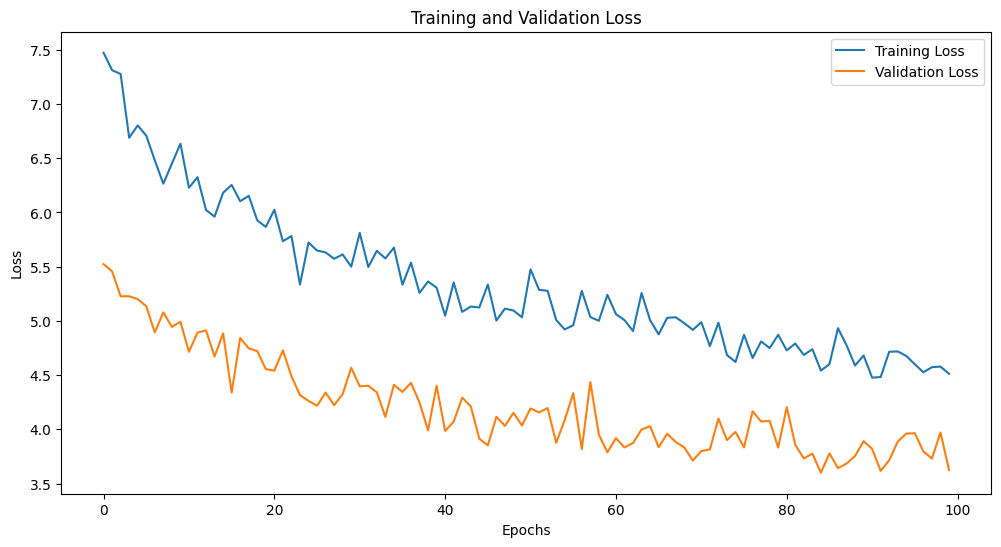

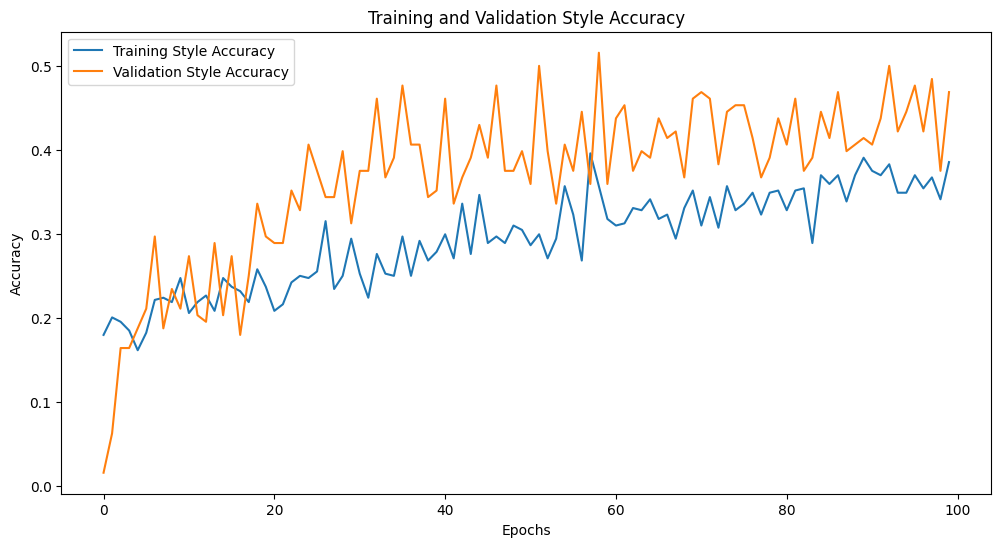

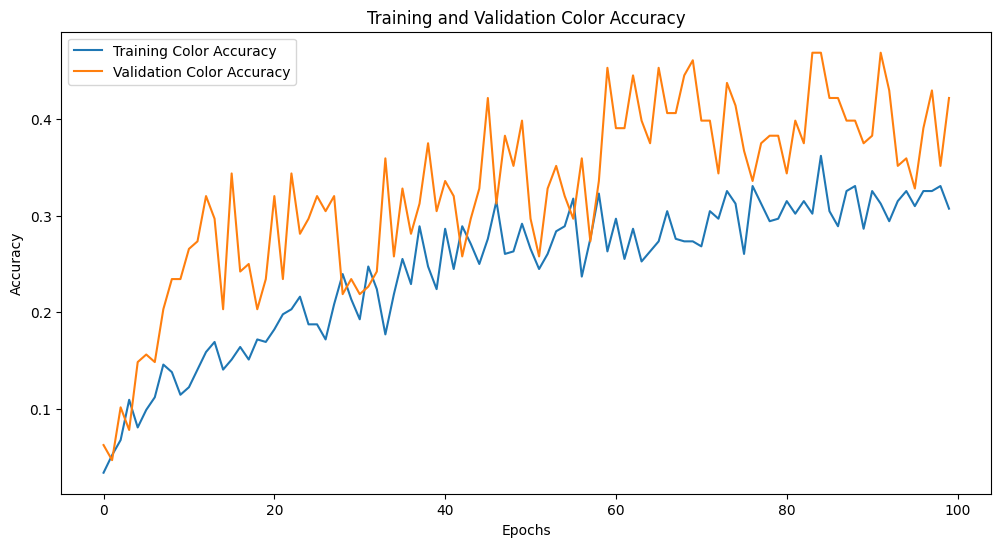

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# 학습률 초기값 3e-4
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

# reduce_learning_rate = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
#     min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-15-46d5ff4787c7>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 7.6246 - style_loss: 3.1628 - color_loss: 4.4619 - style_accuracy: 0.1562 - color_accuracy: 0.0677
Epoch 1: val_loss improved from inf to 5.33870, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 7s 758ms/step - loss: 7.6246 - style_loss: 3.1628 - color_loss: 4.4619 - style_accuracy: 0.1562 - color_accuracy: 0.0677 - val_loss: 5.3387 - val_style_loss: 2.0434 - val_color_loss: 3.2953 - val_style_accuracy: 0.1641 - val_color_accuracy: 0.0859
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 7.0805 - style_loss: 2.8505 - color_loss: 4.2300 - style_accuracy: 0.1979 - color_accuracy: 0.0807
Epoch 2: val_loss did not improve from 5.33870
5/5 [==============================] - 3s 462ms/step - loss: 7.0805 - style_loss: 2.8505 - color_loss: 4.2300 - style_accuracy: 0.1979 - color_accuracy: 0.0807 - val_loss: 5.7433 - val_style_loss: 2.2127 - val_color_loss: 3.5306 - val_style_a

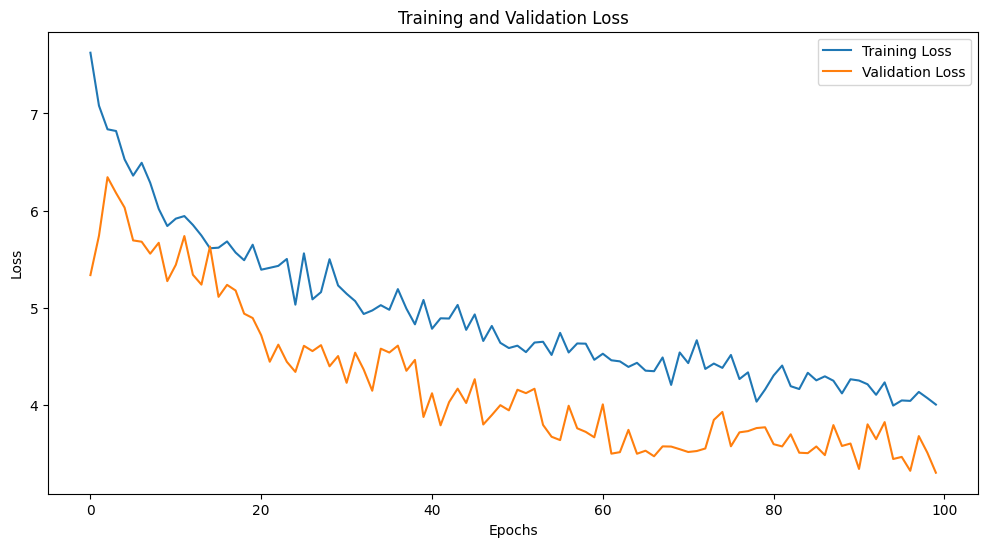

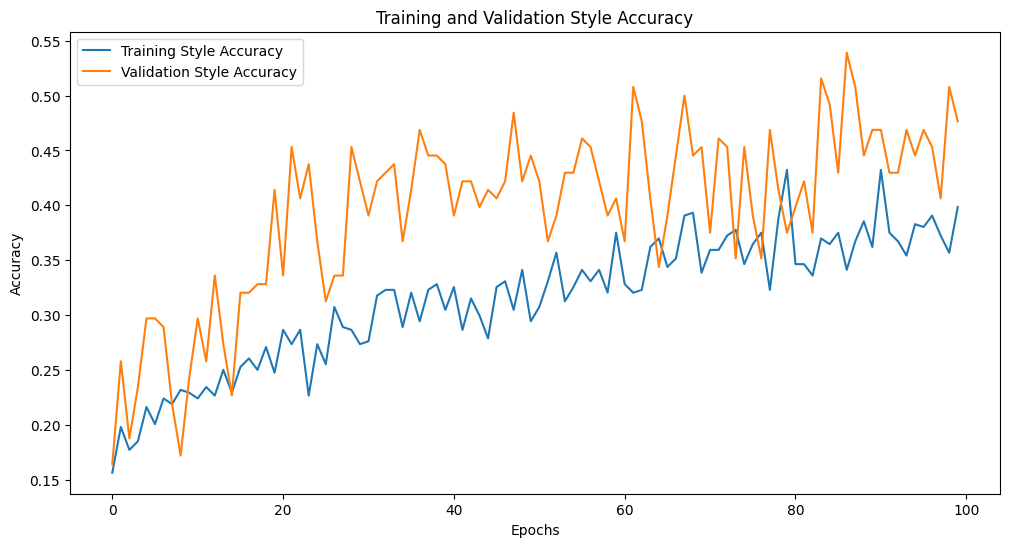

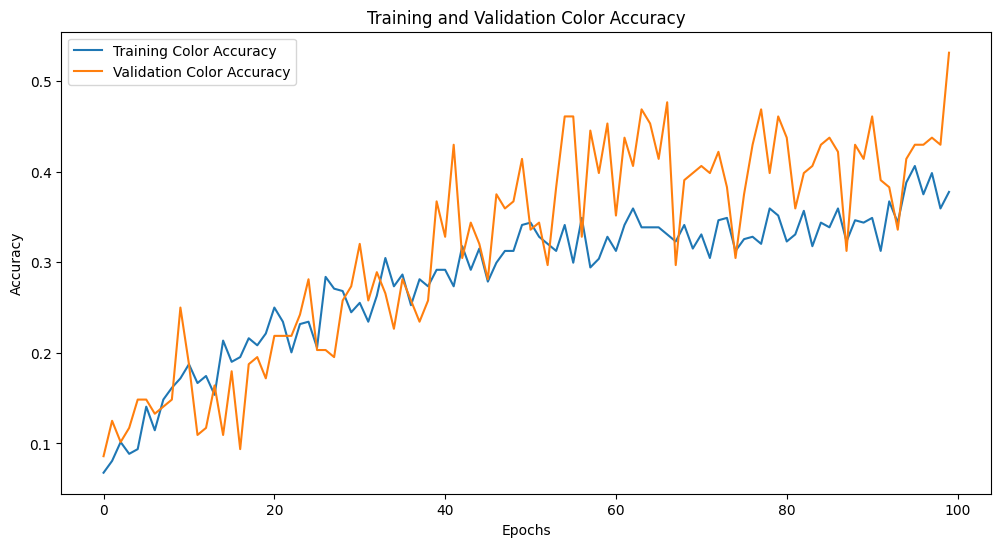

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# 학습률 초기값 0.1, reduce_learning_rate 사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 0.1), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, reduce_learning_rate],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

Epoch 1/100


<ipython-input-11-ecd3aaafb29e>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


6/5 [==============================] - ETA: 0s - loss: 8.6556 - style_loss: 3.6344 - color_loss: 5.0212 - style_accuracy: 0.1771 - color_accuracy: 0.1302
Epoch 1: val_loss improved from inf to 202.39993, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 6s 679ms/step - loss: 8.6556 - style_loss: 3.6344 - color_loss: 5.0212 - style_accuracy: 0.1771 - color_accuracy: 0.1302 - val_loss: 202.3999 - val_style_loss: 78.0036 - val_color_loss: 124.3963 - val_style_accuracy: 0.2031 - val_color_accuracy: 0.0703 - lr: 0.1000
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 7.1628 - style_loss: 2.8877 - color_loss: 4.2751 - style_accuracy: 0.1875 - color_accuracy: 0.1589
Epoch 2: val_loss improved from 202.39993 to 53.10529, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 3s 618ms/step - loss: 7.1628 - style_loss: 2.8877 - color_loss: 4.2751 - style_accuracy: 0.1875 - color_accuracy: 0.1589 - val_loss: 53.1053 - 

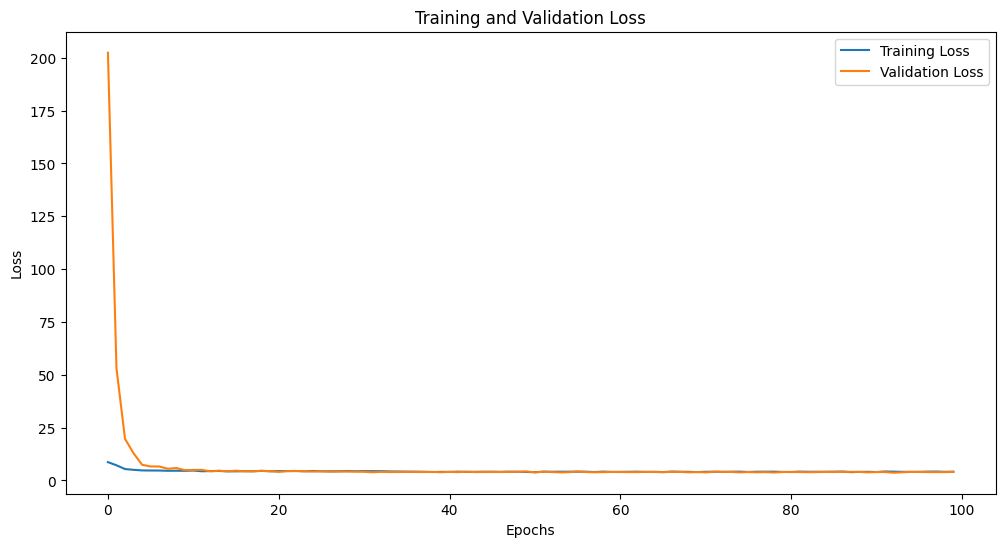

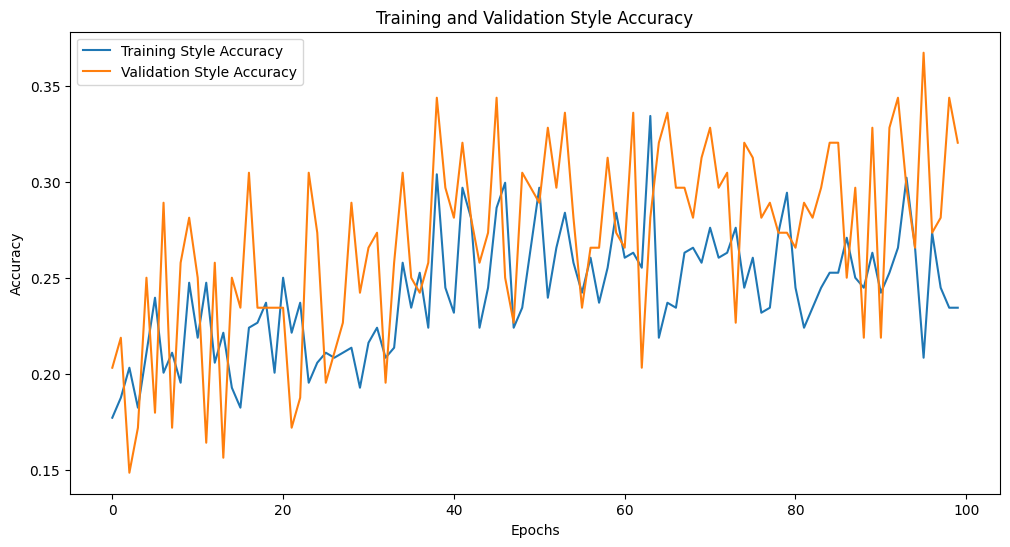

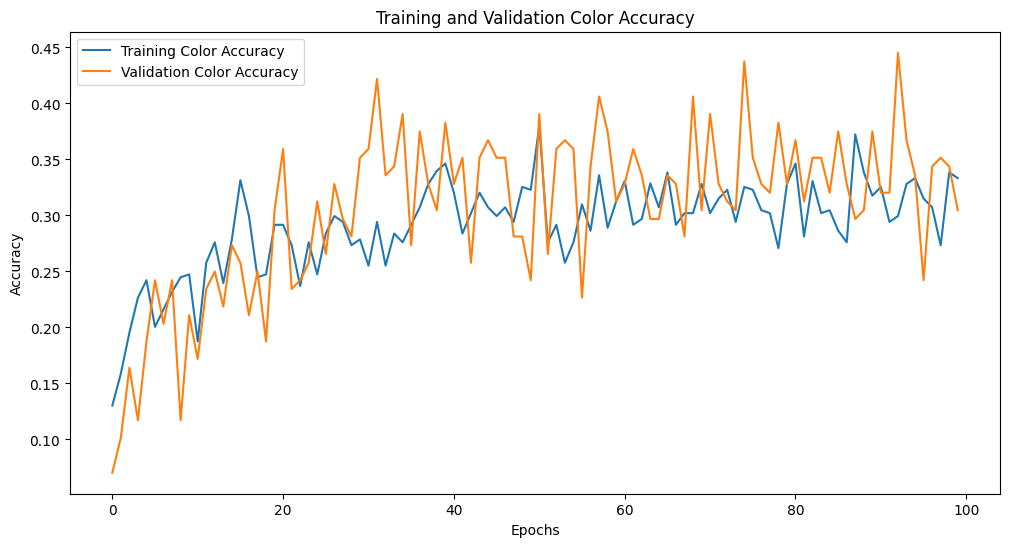

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

In [ ]:
# 학습률 초기값 0.1, reduce_learning_rate(하한 3e-5)사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 0.1), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     mode='min',
#     verbose=1
# )

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=3e-5)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, reduce_learning_rate],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-17-df2f5e061407>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 8.5170 - style_loss: 3.6371 - color_loss: 4.8798 - style_accuracy: 0.1771 - color_accuracy: 0.0703
Epoch 1: val_loss improved from inf to 288.03284, saving model to feature_extraction_VGG_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 7s 842ms/step - loss: 8.5170 - style_loss: 3.6371 - color_loss: 4.8798 - style_accuracy: 0.1771 - color_accuracy: 0.0703 - val_loss: 288.0328 - val_style_loss: 134.1856 - val_color_loss: 153.8473 - val_style_accuracy: 0.1484 - val_color_accuracy: 0.0234 - lr: 0.1000
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 7.1273 - style_loss: 2.6863 - color_loss: 4.4410 - style_accuracy: 0.2031 - color_accuracy: 0.1432
Epoch 2: val_loss improved from 288.03284 to 50.14600, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 4s 704ms/step - loss: 7.1273 - style_loss: 2.6863 - color_loss: 4.4410 - style_accuracy: 0.2031 - color_accuracy: 0.1432 - val_loss: 50.1460 - val_style_loss: 14.6228 - val_color_loss: 35.5232 - val_style_accuracy: 0.1953 - val_color_accuracy: 0.0391 - lr: 0.1000
Epoch 3/100
6/5 [==============================] - ETA: 0s - loss: 5.2454 - style_loss: 2.1657 - color_loss: 3.0797 - style_ac

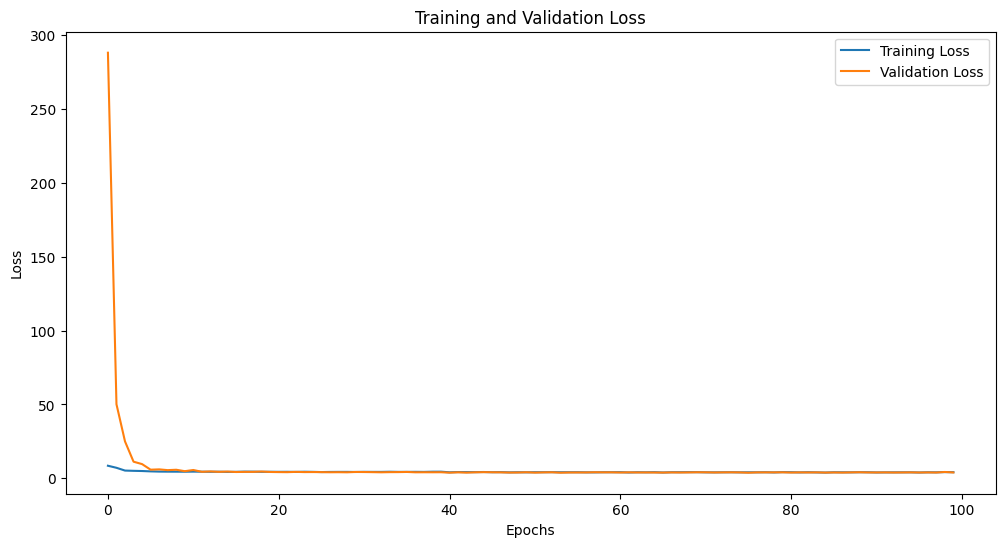

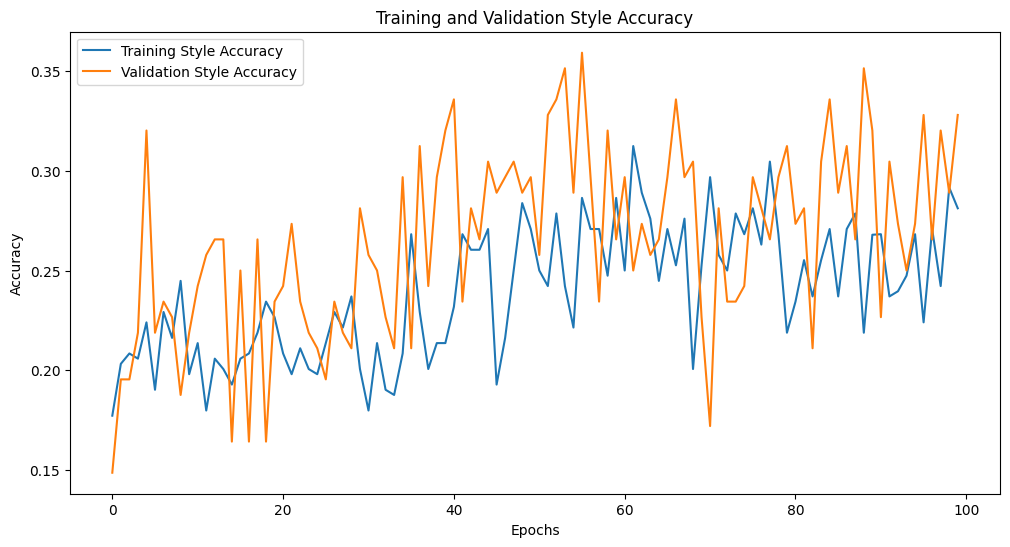

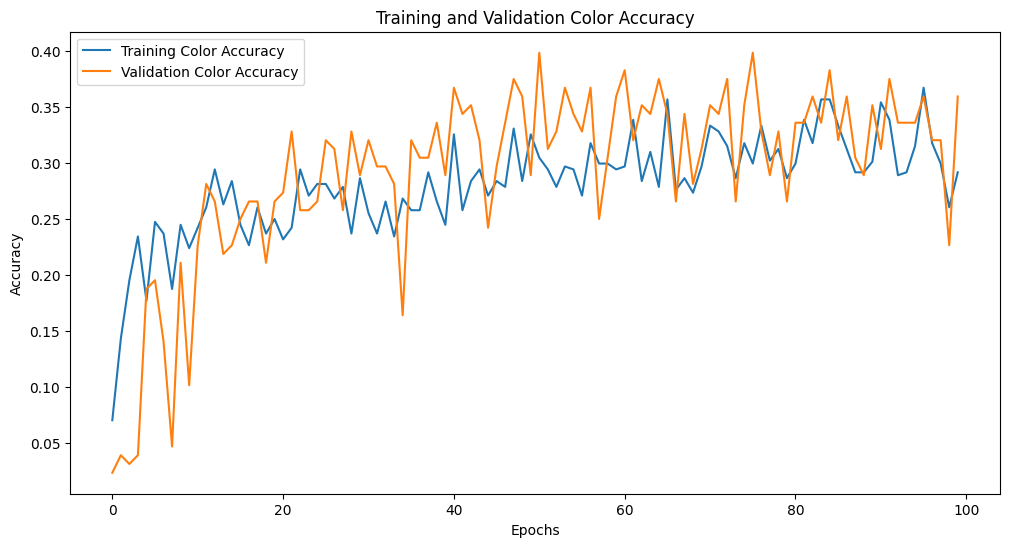

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)